In [17]:
import pickle
import os
import re
from utils_wiki import get_category_data
from utils_network import filter_graph_by_attribute, count_nodes_by_attribute, plot_all_models_linear, plot_all_models_loglog, model_fitting, plot_centrality_comparison, process_and_visualize_subfields
from utils_globals import *
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

# Load the graph
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

In [18]:
# Print original number of nodes and edges
print("Original graph: ")
print(f"Nodes: {S.number_of_nodes()}, Edges: {S.number_of_edges()}")
print(f"Undirected graph: ")
print(f"Nodes: {S_undirected.number_of_nodes()}, Edges: {S_undirected.number_of_edges()}")

Original graph: 
Nodes: 1362, Edges: 10732
Undirected graph: 
Nodes: 1362, Edges: 8895


# Subfields communities

In [19]:
philosopher_subfield_info = pickle.load(open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "rb"))

S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("Subfield graph: ", S_subfields)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)

Did not find subfields for: 768 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Johann_Augustus_Eberhard', 'Judah_Leon_Abravanel', 'William_of_Moerbeke']
Original graph: 1362 nodes and 8895 edges
Filtered 'subfields' graph: 594 nodes and 4223 edges
Subfield graph:  Graph with 594 nodes and 4223 edges
--------------------------------------------------
Number of nodes by subfields:
 -> logicians: 89
 -> philosophers of science: 45
 -> ethicists: 115
 -> critical theorists: 41
 -> sociopolitical thinkers: 131
 -> political philosophers: 135
 -> epistemologists: 78
 -> secular humanists: 34
 -> metaphysicians: 119
 -> philosophers of language: 68
 -> utilitarians: 29
 -> political theorists: 73
 -> rationalists: 17
 -> aestheticians: 51
 -> philosophers of religion: 49
 -> existentialists: 7
 -> philosophers of mind: 57
 -> environmental philosophers: 8
 -> feminist philosophers: 22
 -> phenomenologists: 11
---------------------------------------

## First: Check full filtered network statistics

### Anyone important missing?

In [20]:
# Get degrees for all nodes in the original graph
degree_dict = dict(S_undirected.degree())

# Check if each node is in the filtered graph
presence = {node: (node in S_subfields) for node in S_undirected.nodes()}

# Combine degree and presence information
degree_data = [
    {'node': node, 'degree': degree, 'present': presence[node]}
    for node, degree in degree_dict.items()
]

# Sort nodes by degree in descending order
degree_data = sorted(degree_data, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes = [entry['node'] for entry in degree_data]
degrees = [entry['degree'] for entry in degree_data]
colors = ['blue' if entry['present'] else 'red' for entry in degree_data]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes))),
            y=degrees,
            marker_color=colors,
            text=nodes,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Original Graph (Red: Missing in Filtered Graph)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()


In [21]:
# print top nodes not present in the subfield graph
print("Most important philosophers not present in the subfield graph:")
for entry in degree_data[:1000]:
    if not entry['present']:
        print(entry['node'], entry['degree'])

Most important philosophers not present in the subfield graph:
Isaac_Newton 72
Plutarch 58
Homer 46
Seneca_the_Younger 41
Ernst_Laas 39
Dante_Alighieri 37
Pierre_Gassendi 34
Wilhelm_Wundt 34
Galen 33
Peter_Lombard 28
Lucian 28
Alexandre_Kojève 27
Nicolaus_Copernicus 27
Denis_Diderot 26
Jean_Wahl 26
Moses_Mendelssohn 25
Johannes_Kepler 25
Samuel_Clarke 25
Giordano_Bruno 24
Ernst_Cassirer 24
Rudolf_Otto 24
Kuno_Fischer 24
Miguel_Abensour 24
Karl_Jaspers 23
Franz_Kafka 23
Epictetus 23
William_Blake 22
Christiaan_Huygens 22
Carl_Jung 22
Joseph_Butler 22
Edward_Gibbon 22
William_Hazlitt 22
Benjamin_Fondane 22
Lev_Shestov 21
Ralph_Cudworth 21
Emil_Cioran 21
Josiah_Royce 21
Paul_Ricœur 21
George_Eliot 21
Jean-Luc_Nancy 21
Étienne_Bonnot_de_Condillac 21
Clement_of_Alexandria 21
Ludwig_Klages 20
Mikhail_Bakhtin 20
Friedrich_Heinrich_Jacobi 20
Karl_Barth 20
Mahatma_Gandhi 19
Gorgias 19
Hermann_Weyl 19
Marcus_Aurelius 19
Paul_de_Man 18
Alexander_Pope 18
Ptolemy 18
Zhu_Xi 18
Bruno_Bauer 18
Marcel_

### Remove free nodes

In [22]:
# remove nodes that are not connected to the main component
largest_component = max(nx.connected_components(S_subfields), key=len)
#print nodes that are not in the largest component
for node in S_subfields.nodes:
    if node not in largest_component:
        print("Node not in largest component: ", node)
        print("Node attributes: ", S_subfields.nodes[node])


S_subfields = S_subfields.subgraph(largest_component).copy()
print("Subfield graph after removing unconnected nodes: ", S_subfields)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)

Node not in largest component:  Marcion_of_Sinope
Node attributes:  {'contentlength': 2573, 'subfields': ['ethicists']}
Node not in largest component:  Hayashi_Razan
Node attributes:  {'contentlength': 1579, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Ogyū_Sorai
Node attributes:  {'contentlength': 2172, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Yi_I
Node attributes:  {'contentlength': 1546, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Dong_Zhongshu
Node attributes:  {'contentlength': 986, 'subfields': ['sociopolitical thinkers']}
Subfield graph after removing unconnected nodes:  Graph with 589 nodes and 4222 edges
--------------------------------------------------
Number of nodes by subfields:
 -> logicians: 89
 -> philosophers of science: 45
 -> ethicists: 114
 -> critical theorists: 41
 -> sociopolitical thinkers: 127
 -> political philosophers: 135
 -> epistemologists: 78
 -> secular humanists

### Fit degree distribution to subfields graph

In [23]:
import numpy as np
import networkx as nx
from scipy.stats import poisson, expon, lognorm

# Step 2: Extract the degree sequence
degrees = np.array([d for n, d in S_subfields.degree()])
fitted_models = model_fitting(degrees)


Minimum degree: 1
Maximum degree: 157

Model fitting results:
-----------------------
Log-Likelihoods:
-Poisson: -4818.9
-Exponential: -2157.4
-Log-Normal: -2115.0
-Power-Law: -2369.9

AIC values:
-Poisson: 9639.83 
-Exponential: 4316.76 
-Log-Normal: 4234.04 <- Best fit
-Power-Law: 4743.79 

BIC Values:
-Poisson: 9644.2 
-Exponential: 4321.1 
-Log-Normal: 4242.8 <- Best fit
-Power-Law: 4752.6 

Estimated parameters:
---------------------
Poisson lambda: 14.34
Exponential lambda: 0.0698
Log-Normal sigma: 0.9491, scale: 9.25
Power-Law alpha: 1.45, xmin: 1.0


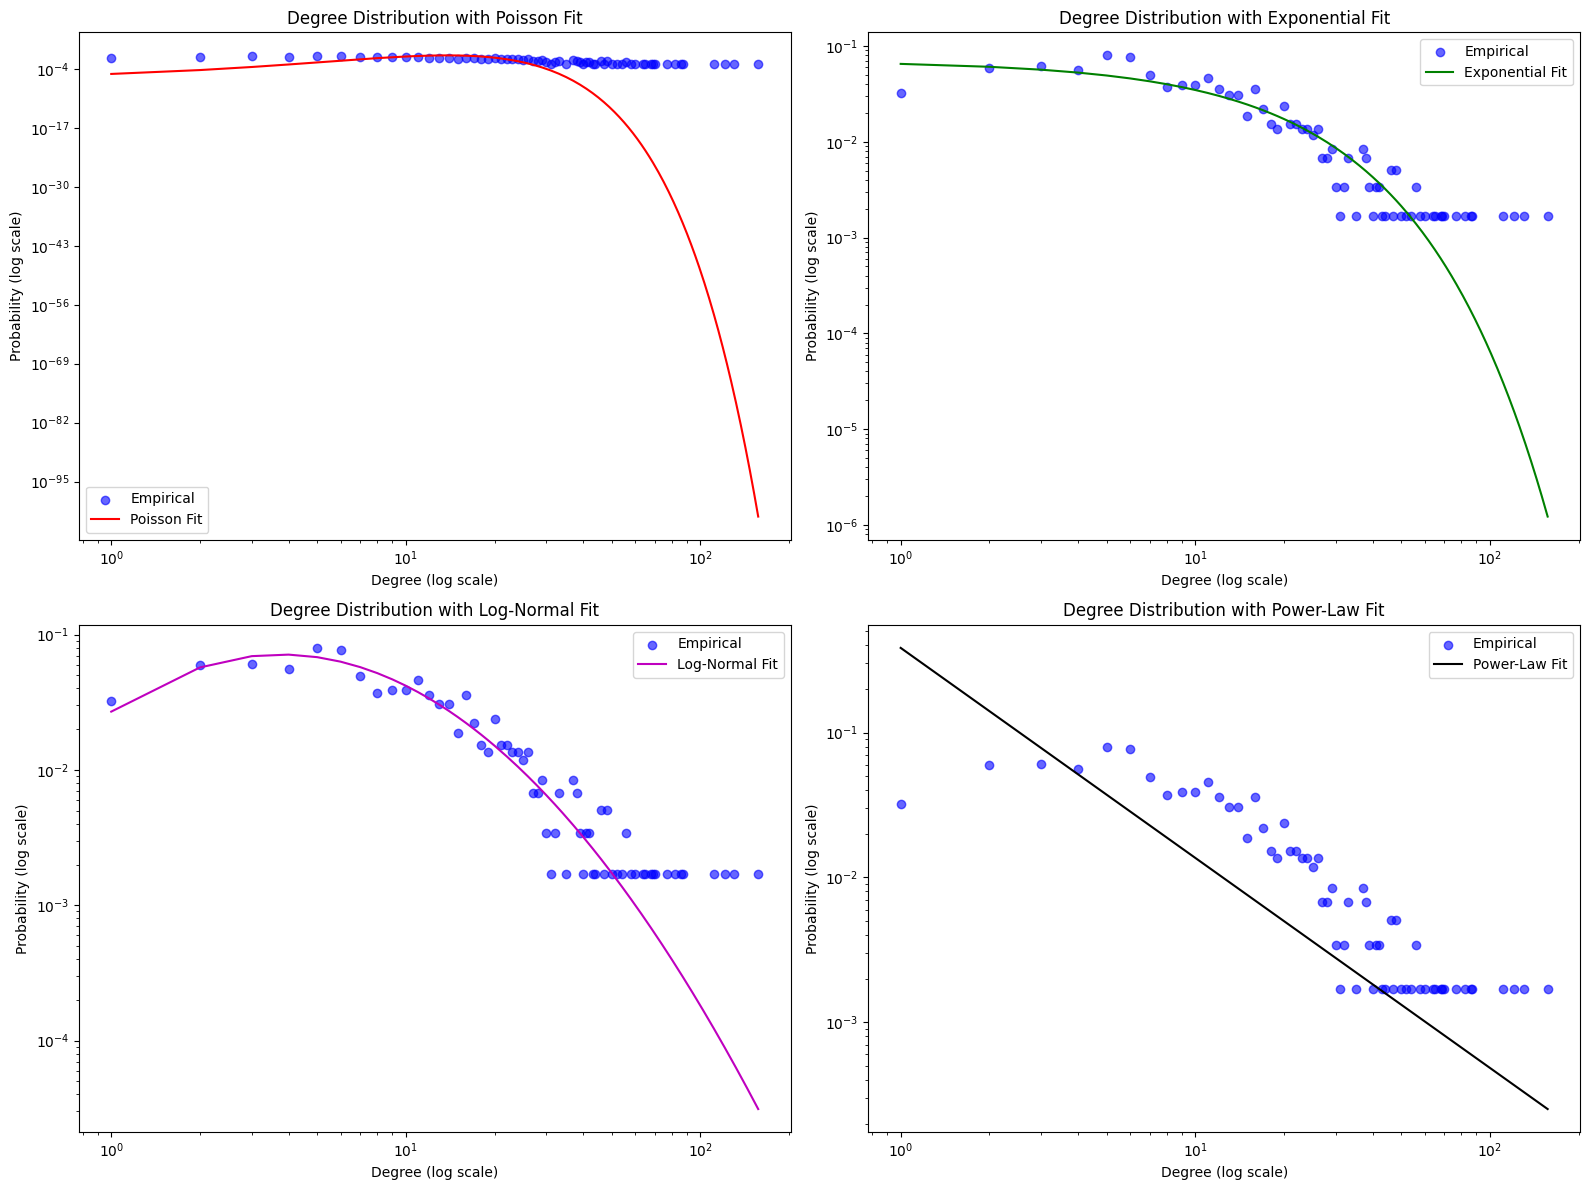

In [24]:
plot_all_models_loglog(degrees, fitted_models)

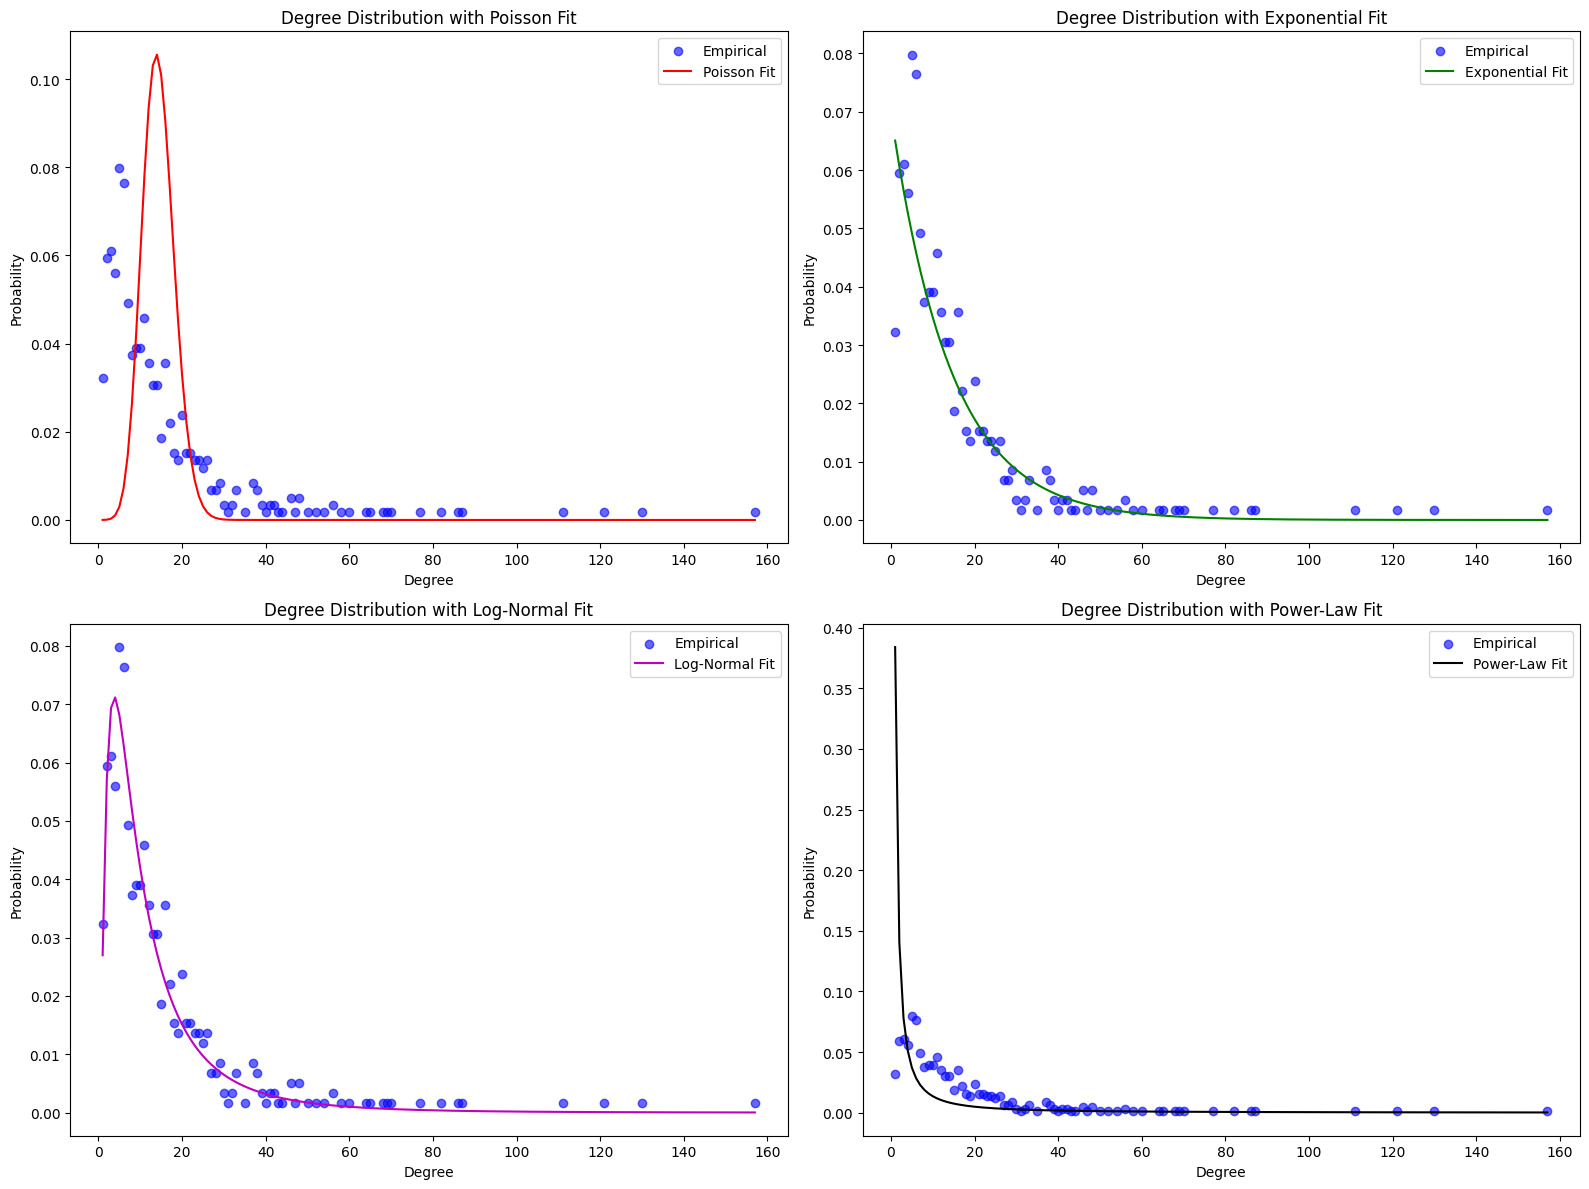

In [25]:
# Call the new function
plot_all_models_linear(degrees, fitted_models)

### Nodes analysis (like centrality)

In [26]:
# Get degrees for nodes in the filtered graph (S_subfields)
degree_dict_subfields = dict(S_subfields.degree())

# Combine node names and degrees
degree_data_subfields = [
    {'node': node, 'degree': degree} for node, degree in degree_dict_subfields.items()
]

# Sort nodes by degree in descending order
degree_data_subfields = sorted(degree_data_subfields, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes_subfields = [entry['node'] for entry in degree_data_subfields]
degrees_subfields = [entry['degree'] for entry in degree_data_subfields]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes_subfields))),
            y=degrees_subfields,
            marker_color='blue',  # All bars in blue
            text=nodes_subfields,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Filtered Graph (S_subfields)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()

In [27]:
# Print top 30 highest centrality nodes
sorted_centrality = sorted(nx.degree_centrality(S_subfields).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by degree centrality:")
for node, centrality in sorted_centrality[:30]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")


Top 30 nodes by degree centrality:
Node: Aristotle, Degree Centrality: 0.2670
Node: Immanuel_Kant, Degree Centrality: 0.2211
Node: Plato, Degree Centrality: 0.2058
Node: Karl_Marx, Degree Centrality: 0.1888
Node: David_Hume, Degree Centrality: 0.1480
Node: Friedrich_Nietzsche, Degree Centrality: 0.1463
Node: Ludwig_Wittgenstein, Degree Centrality: 0.1395
Node: Bertrand_Russell, Degree Centrality: 0.1310
Node: Martin_Heidegger, Degree Centrality: 0.1190
Node: René_Descartes, Degree Centrality: 0.1173
Node: Edmund_Husserl, Degree Centrality: 0.1156
Node: Thomas_Aquinas, Degree Centrality: 0.1105
Node: John_Locke, Degree Centrality: 0.1088
Node: Jacques_Derrida, Degree Centrality: 0.1020
Node: Michel_Foucault, Degree Centrality: 0.0986
Node: Heraclitus, Degree Centrality: 0.0952
Node: Sigmund_Freud, Degree Centrality: 0.0952
Node: John_Stuart_Mill, Degree Centrality: 0.0918
Node: Henri_Bergson, Degree Centrality: 0.0884
Node: Arthur_Schopenhauer, Degree Centrality: 0.0850
Node: Augustine

In [28]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
page_rank = nx.pagerank(S_subfields)
betweenness_centrality = nx.betweenness_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)
eigenvector_centrality = nx.eigenvector_centrality(S_subfields)
clustering = nx.clustering(S_subfields)

# Plot comparisons
plot_centrality_comparison(S_subfields, degree_centrality, page_rank, 
                           "Degree Centrality", "PageRank", 
                           "Degree Centrality vs PageRank")

plot_centrality_comparison(S_subfields, degree_centrality, betweenness_centrality, 
                           "Degree Centrality", "Betweenness Centrality", 
                           "Degree Centrality vs Betweenness Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, closeness_centrality, 
                           "Degree Centrality", "Closeness Centrality", 
                           "Degree Centrality vs Closeness Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, eigenvector_centrality, 
                           "Degree Centrality", "Eigenvector Centrality", 
                           "Degree Centrality vs Eigenvector Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, clustering, 
                           "Degree Centrality", "Clustering Coefficient", 
                           "Degree Centrality vs Clustering Coefficient")



### Graph of the entire network

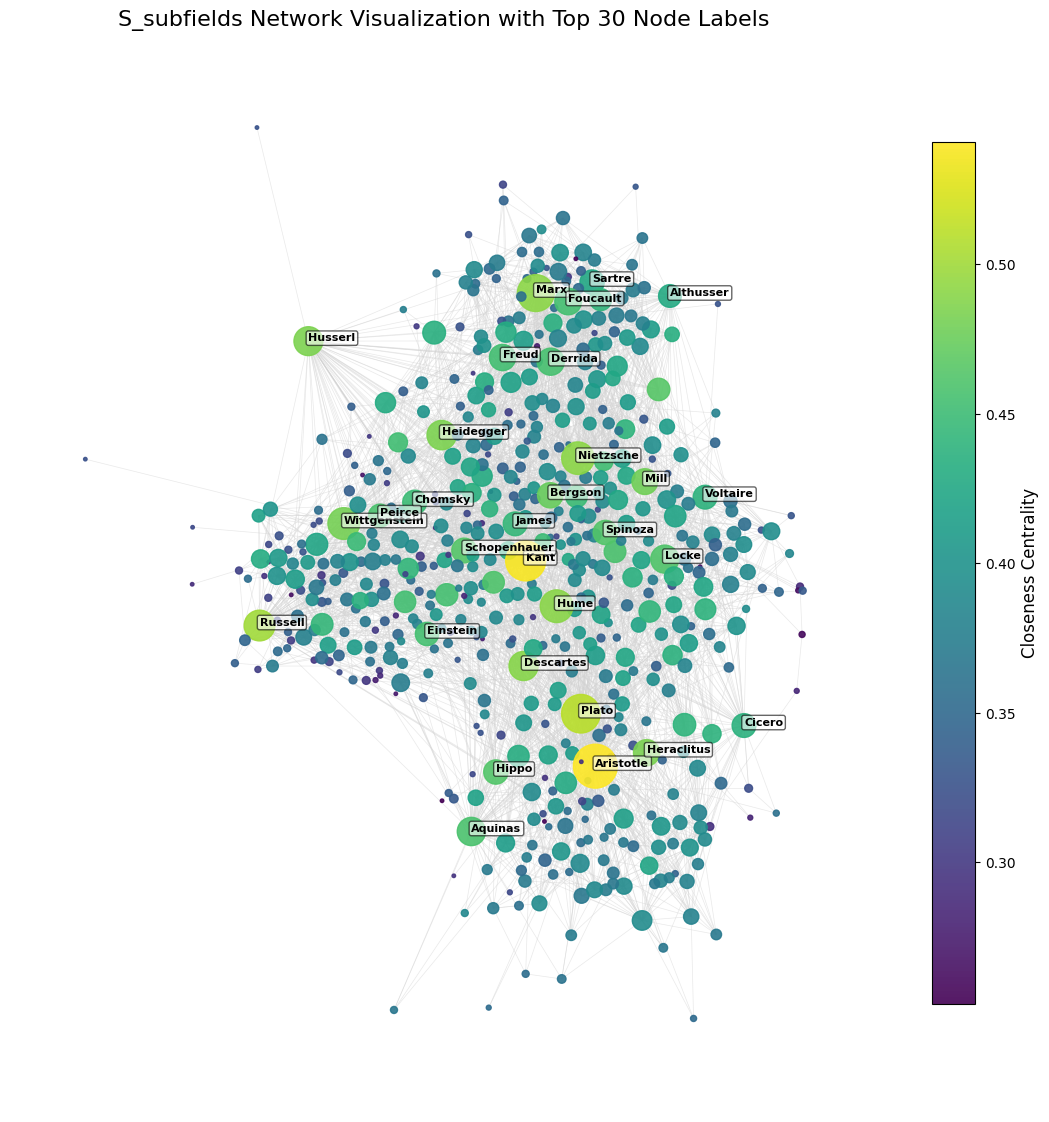

In [29]:
#%pip install fa2_modified
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Normalize closeness centrality for node colors
closeness_values = np.array(list(closeness_centrality.values()))
min_closeness, max_closeness = closeness_values.min(), closeness_values.max()
normalized_colors = (closeness_values - min_closeness) / (max_closeness - min_closeness)

# Color map for nodes based on closeness centrality
cmap = plt.cm.viridis
node_colors = [cmap(value) for value in normalized_colors]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Initialize and apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.05,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(S_subfields, pos=None, iterations=2000)

# Plot the network
fig, ax = plt.subplots(figsize=(14, 14))

# Draw nodes, passing closeness centrality values directly
nodes = nx.draw_networkx_nodes(
    S_subfields,
    positions,
    node_size=node_sizes,
    node_color=closeness_values,
    cmap=cmap,
    alpha=0.9,
    ax=ax
)

# Draw edges
nx.draw_networkx_edges(
    S_subfields,
    positions,
    edge_color='lightgray',
    alpha=0.5,
    width=0.5,
    ax=ax
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    ax.text(
        x, y,
        last_name,
        fontsize=8,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding color bar for closeness centrality using the nodes object
cbar = fig.colorbar(nodes, ax=ax, shrink=0.8)
cbar.set_label('Closeness Centrality', fontsize=12)

# Add title and turn off axis
ax.set_title("S_subfields Network Visualization with Top 30 Node Labels", fontsize=16)
ax.axis('off')
plt.show()

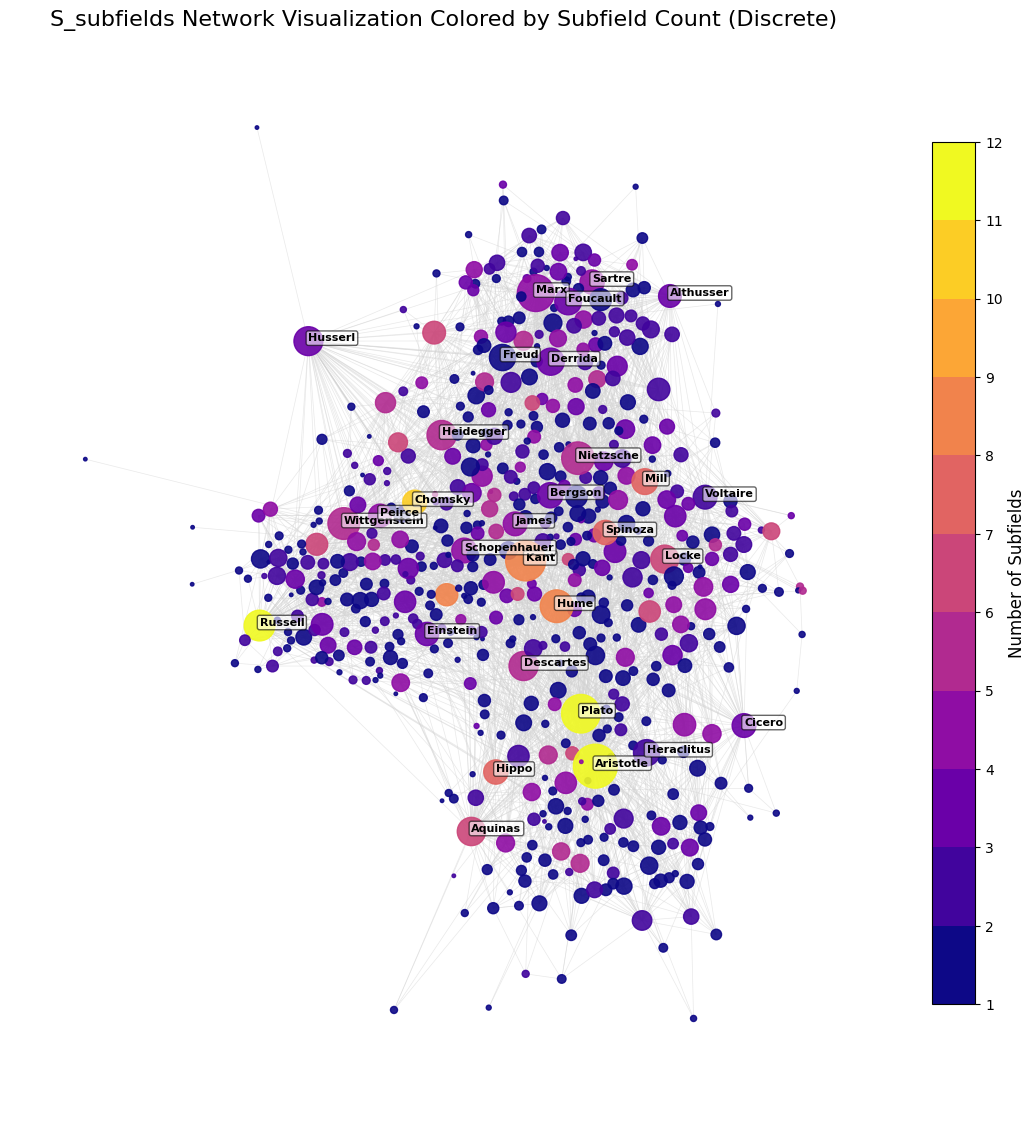

In [30]:

import matplotlib.colors as mcolors

# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Get the count of subfields for each node
subfield_counts = {node: len(attrs['subfields']) for node, attrs in S_subfields.nodes(data=True)}

# Define a discrete colormap
max_subfields = max(subfield_counts.values())
bounds = np.arange(1, max_subfields + 2)  # 1 to max_subfields (inclusive)
cmap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Map discrete values to colors

# Map subfield counts to colors
node_colors = [cmap(norm(count)) for count in subfield_counts.values()]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Plot the network
fig, ax = plt.subplots(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_subfields, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9,
    ax=ax
)
nx.draw_networkx_edges(
    S_subfields, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5,
    ax=ax
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    ax.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding discrete color bar for subfield counts
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=bounds, shrink=0.8)
cbar.set_label('Number of Subfields', fontsize=12)

# Add title and turn off axis
plt.title("S_subfields Network Visualization Colored by Subfield Count (Discrete)", fontsize=16)
plt.axis('off')
plt.show()


In [31]:
# Sort nodes by degree centrality in descending order
top_20_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]

# Print the subfields for the top 20 nodes
print("Subfields of the Top 20 Nodes by Degree Centrality:")
for i, node in enumerate(top_20_nodes, start=1):
    subfields = S_subfields.nodes[node].get('subfields', [])
    print(f"{i}. {node}: {', '.join(subfields)}")

Subfields of the Top 20 Nodes by Degree Centrality:
1. Aristotle: aestheticians, epistemologists, ethicists, logicians, metaphysicians, sociopolitical thinkers, philosophers of language, philosophers of mind, philosophers of religion, political philosophers, political theorists
2. Immanuel_Kant: aestheticians, epistemologists, ethicists, metaphysicians, sociopolitical thinkers, philosophers of religion, political philosophers, political theorists
3. Plato: aestheticians, epistemologists, ethicists, logicians, metaphysicians, sociopolitical thinkers, philosophers of language, philosophers of religion, political philosophers, political theorists, rationalists
4. Karl_Marx: secular humanists, sociopolitical thinkers, political philosophers, political theorists
5. David_Hume: aestheticians, epistemologists, ethicists, sociopolitical thinkers, philosophers of mind, philosophers of religion, philosophers of science, political philosophers
6. Friedrich_Nietzsche: aestheticians, ethicists, soc

## Community specific metrics

Processing subfield: sociopolitical thinkers
Top 10 nodes by centrality for subfield 'sociopolitical thinkers':
  Degree Centrality:
    Karl_Marx: 0.3889
    Immanuel_Kant: 0.3016
    Aristotle: 0.2778
    Friedrich_Nietzsche: 0.2778
    David_Hume: 0.2302
    Plato: 0.2302
    Michel_Foucault: 0.2143
    John_Stuart_Mill: 0.2143
    Leo_Strauss: 0.1905
    Max_Weber: 0.1667
  Closeness Centrality:
    Karl_Marx: 0.5811
    Immanuel_Kant: 0.5547
    Friedrich_Nietzsche: 0.5400
    Aristotle: 0.5237
    David_Hume: 0.5215
    John_Stuart_Mill: 0.5171
    Michel_Foucault: 0.5064
    Plato: 0.5022
    Leo_Strauss: 0.4961
    John_Locke: 0.4921
  Betweenness Centrality:
    Karl_Marx: 0.1638
    Friedrich_Nietzsche: 0.0935
    Aristotle: 0.0791
    Immanuel_Kant: 0.0789
    David_Hume: 0.0700
    Noam_Chomsky: 0.0545
    Voltaire: 0.0509
    John_Stuart_Mill: 0.0498
    Plato: 0.0427
    Michel_Foucault: 0.0345
  Eigenvector Centrality:
    Karl_Marx: 0.2831
    Immanuel_Kant: 0.2473
    

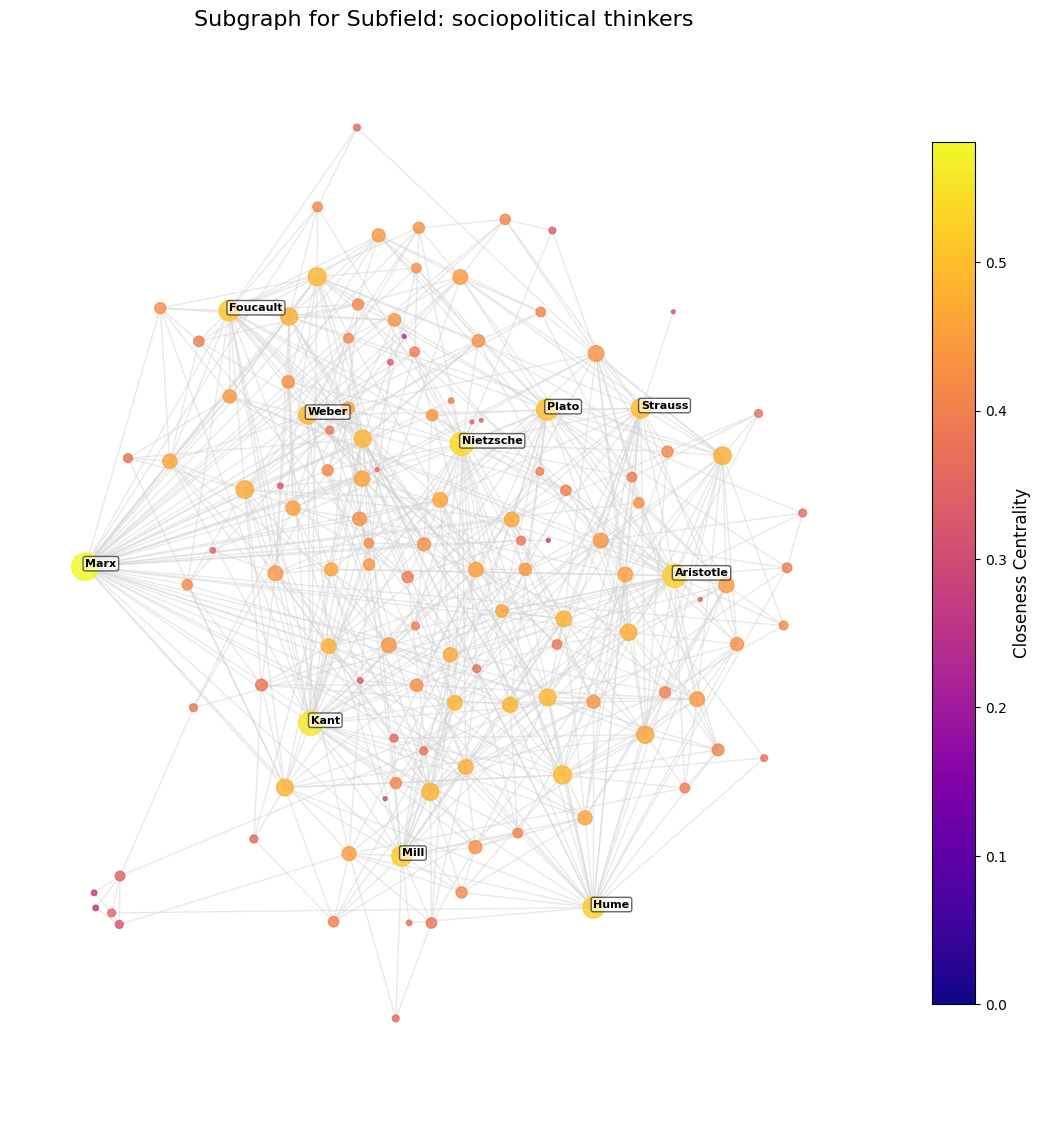

Processing subfield: aestheticians
Top 10 nodes by centrality for subfield 'aestheticians':
  Degree Centrality:
    Immanuel_Kant: 0.4800
    Friedrich_Nietzsche: 0.3600
    Plato: 0.2800
    Jacques_Derrida: 0.2800
    Aristotle: 0.2000
    David_Hume: 0.1800
    Arthur_Schopenhauer: 0.1800
    Thomas_Aquinas: 0.1600
    Georges_Bataille: 0.1400
    Roger_Scruton: 0.1400
  Closeness Centrality:
    Immanuel_Kant: 0.5961
    Friedrich_Nietzsche: 0.5426
    Jacques_Derrida: 0.4755
    Plato: 0.4702
    Arthur_Schopenhauer: 0.4651
    David_Hume: 0.4600
    Augustine_of_Hippo: 0.4600
    Michel_Foucault: 0.4600
    Ayn_Rand: 0.4551
    Roger_Scruton: 0.4502
  Betweenness Centrality:
    Immanuel_Kant: 0.3429
    Friedrich_Nietzsche: 0.1533
    Roger_Scruton: 0.0946
    Jacques_Derrida: 0.0903
    Plato: 0.0691
    Arthur_Schopenhauer: 0.0567
    David_Hume: 0.0395
    Friedrich_Schiller: 0.0373
    Aristotle: 0.0361
    Thomas_Aquinas: 0.0357
  Eigenvector Centrality:
    Immanuel_Kant:

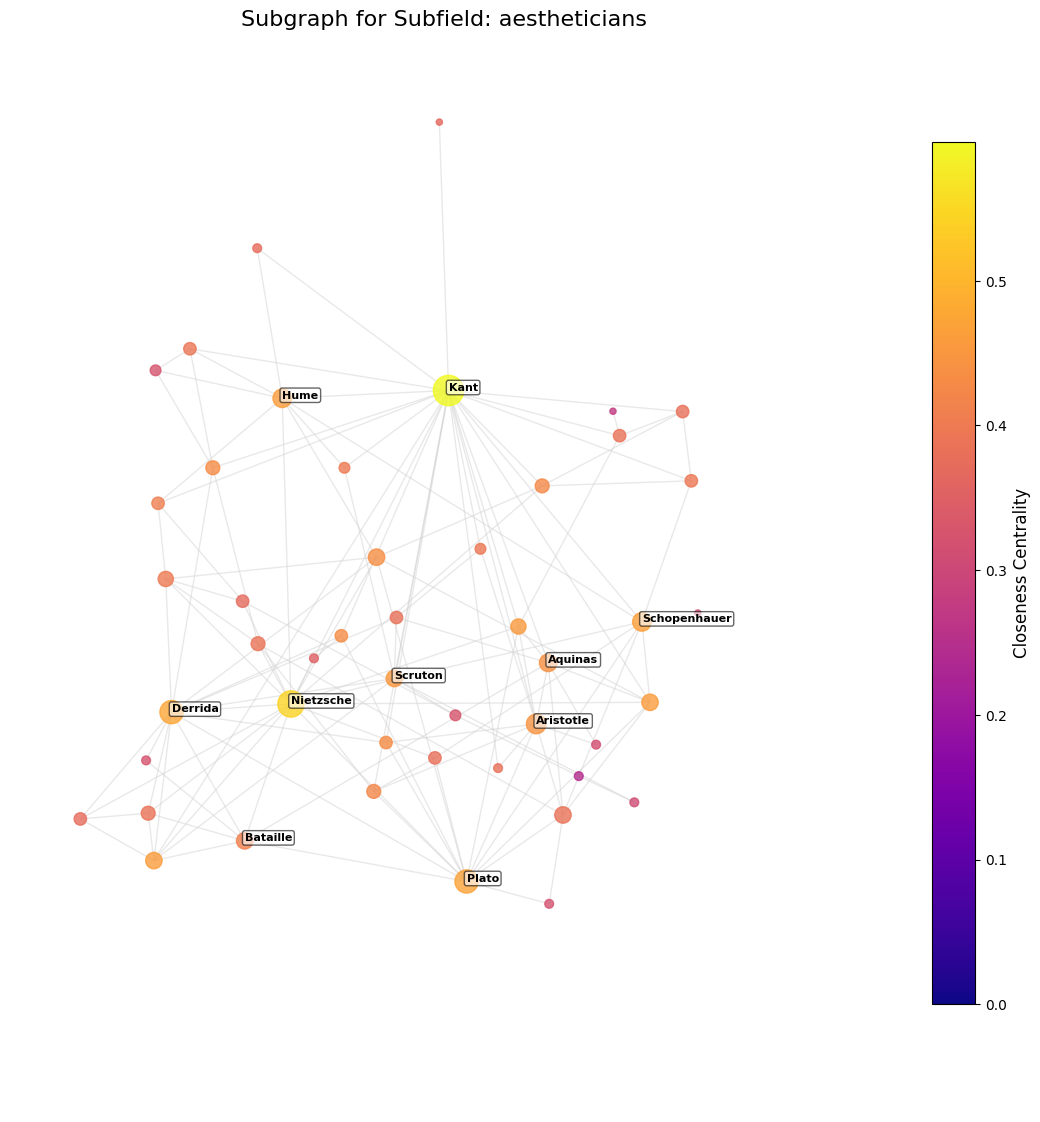

Processing subfield: rationalists
Top 10 nodes by centrality for subfield 'rationalists':
  Degree Centrality:
    Plato: 0.5625
    Maimonides: 0.3750
    Avicenna: 0.3750
    René_Descartes: 0.3750
    Plotinus: 0.3750
    Augustine_of_Hippo: 0.3750
    Al-Farabi: 0.3125
    Pythagoras: 0.3125
    Averroes: 0.3125
    Socrates: 0.2500
  Closeness Centrality:
    Plato: 0.5833
    Avicenna: 0.5568
    Augustine_of_Hippo: 0.5568
    Maimonides: 0.5326
    René_Descartes: 0.5326
    Plotinus: 0.5104
    Al-Farabi: 0.4712
    Pythagoras: 0.4712
    Averroes: 0.4712
    Socrates: 0.4537
  Betweenness Centrality:
    René_Descartes: 0.1987
    Augustine_of_Hippo: 0.1469
    Avicenna: 0.1012
    Plato: 0.0891
    Maimonides: 0.0806
    Baruch_Spinoza: 0.0507
    Plotinus: 0.0392
    Pythagoras: 0.0205
    Socrates: 0.0187
    Averroes: 0.0114
  Eigenvector Centrality:
    Plato: 0.4557
    Plotinus: 0.3303
    Maimonides: 0.3203
    Avicenna: 0.3110
    Al-Farabi: 0.3039
    Averroes: 0.296

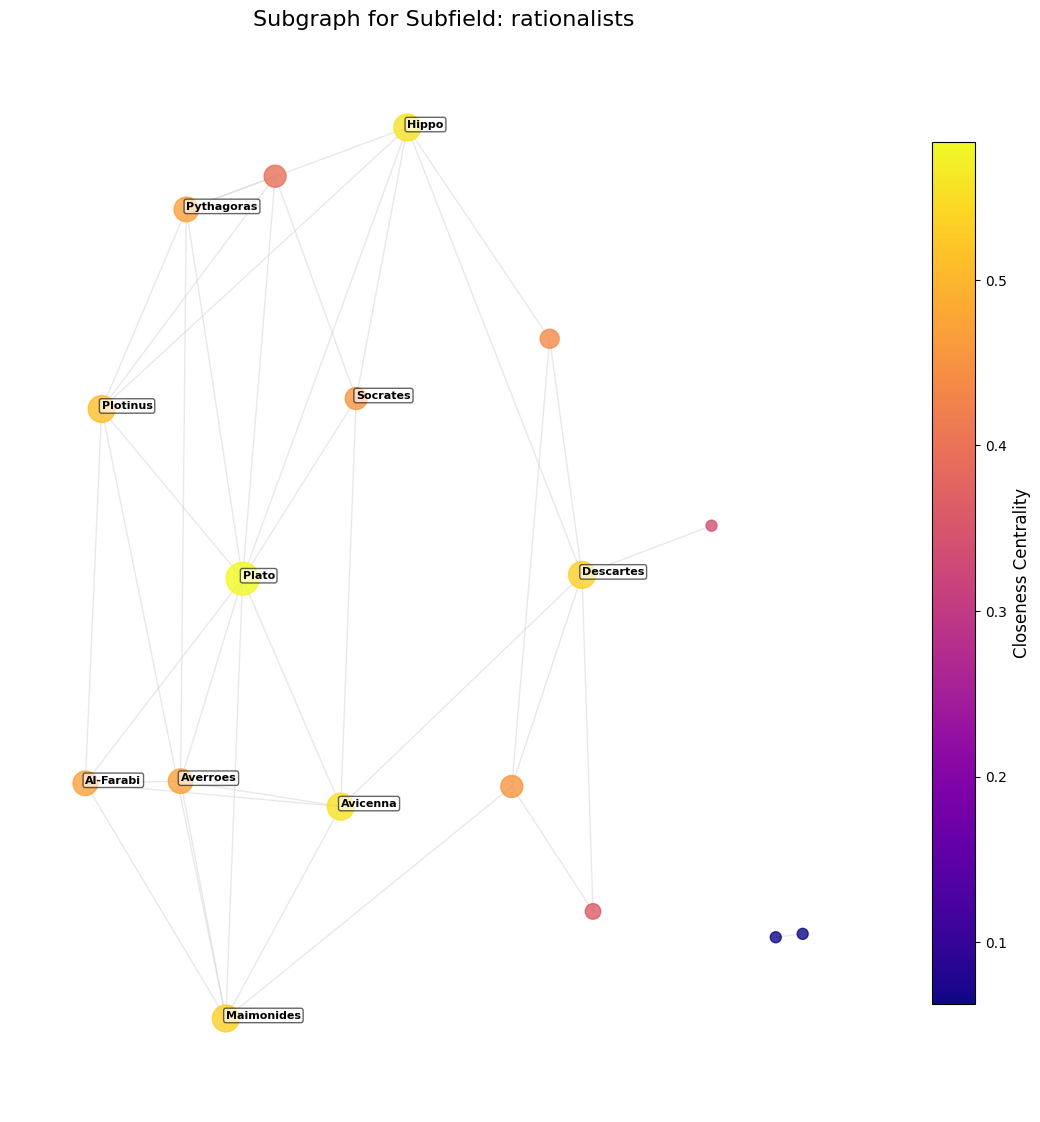

Processing subfield: ethicists
Top 10 nodes by centrality for subfield 'ethicists':
  Degree Centrality:
    Immanuel_Kant: 0.3805
    David_Hume: 0.2832
    Aristotle: 0.2566
    Friedrich_Nietzsche: 0.2478
    Plato: 0.2124
    John_Locke: 0.1947
    John_Stuart_Mill: 0.1947
    Arthur_Schopenhauer: 0.1947
    Bertrand_Russell: 0.1681
    Thomas_Aquinas: 0.1593
  Closeness Centrality:
    Immanuel_Kant: 0.5757
    David_Hume: 0.5381
    Friedrich_Nietzsche: 0.5223
    Aristotle: 0.5173
    John_Stuart_Mill: 0.5027
    Plato: 0.4957
    Bertrand_Russell: 0.4935
    John_Locke: 0.4823
    Arthur_Schopenhauer: 0.4802
    Thomas_Aquinas: 0.4676
  Betweenness Centrality:
    Immanuel_Kant: 0.1856
    David_Hume: 0.1172
    Aristotle: 0.1045
    Friedrich_Nietzsche: 0.0863
    Arthur_Schopenhauer: 0.0626
    John_Stuart_Mill: 0.0609
    Plato: 0.0562
    Bertrand_Russell: 0.0468
    Thomas_Aquinas: 0.0396
    Martin_Heidegger: 0.0369
  Eigenvector Centrality:
    Immanuel_Kant: 0.3512
    

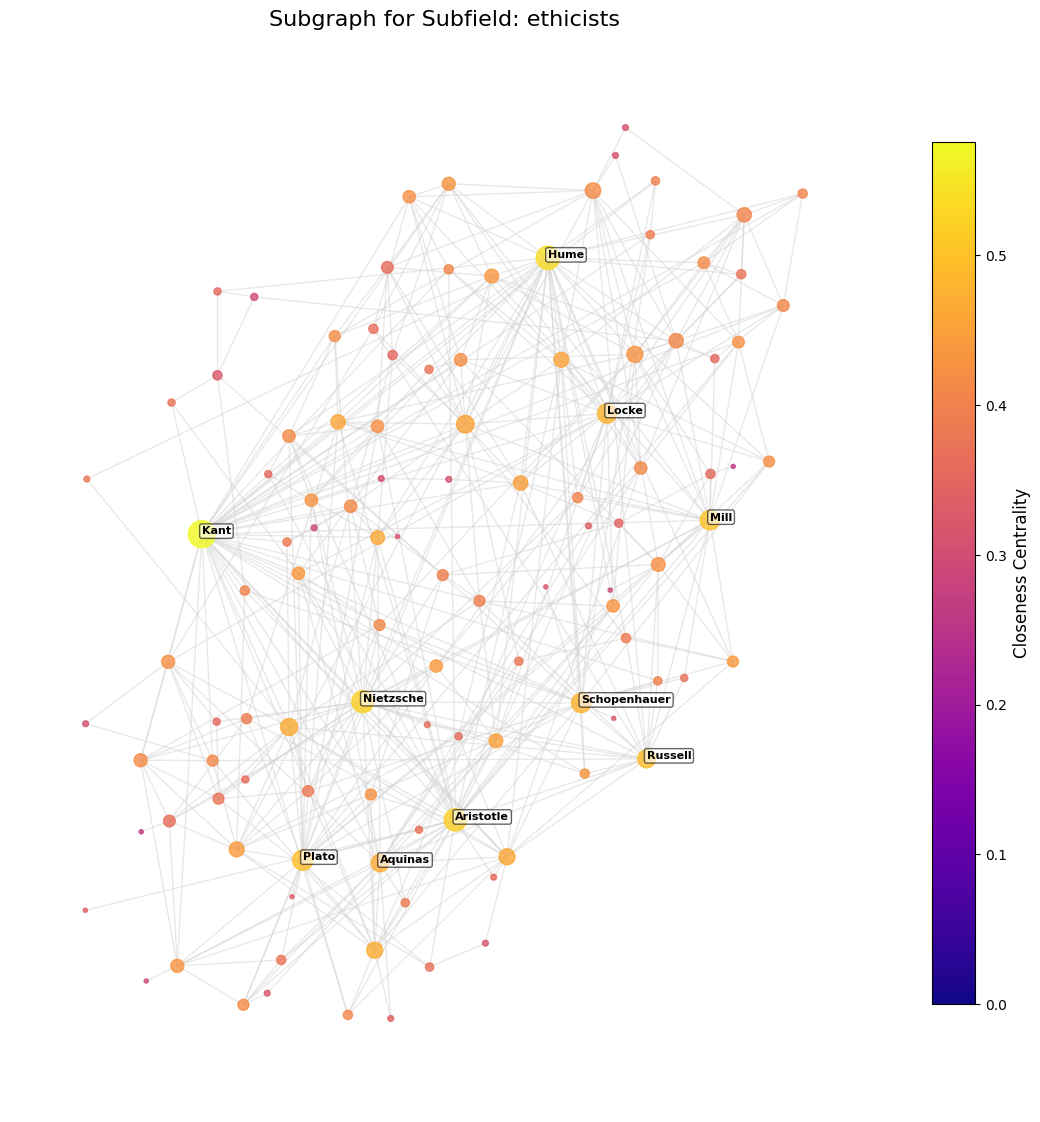

Processing subfield: philosophers of science
Top 10 nodes by centrality for subfield 'philosophers of science':
  Degree Centrality:
    Albert_Einstein: 0.4318
    Paul_Feyerabend: 0.3636
    Karl_Popper: 0.3182
    Bertrand_Russell: 0.2955
    Charles_Sanders_Peirce: 0.2727
    Rudolf_Carnap: 0.2727
    David_Hume: 0.2500
    Hilary_Putnam: 0.2500
    Imre_Lakatos: 0.1818
    Moritz_Schlick: 0.1818
  Closeness Centrality:
    Albert_Einstein: 0.6090
    Paul_Feyerabend: 0.5679
    Karl_Popper: 0.5529
    Charles_Sanders_Peirce: 0.5388
    Rudolf_Carnap: 0.5388
    Bertrand_Russell: 0.5319
    David_Hume: 0.5253
    Hilary_Putnam: 0.5188
    John_Dewey: 0.4886
    Moritz_Schlick: 0.4830
  Betweenness Centrality:
    Albert_Einstein: 0.2258
    Charles_Sanders_Peirce: 0.1523
    Paul_Feyerabend: 0.1443
    Karl_Popper: 0.1056
    Hilary_Putnam: 0.0756
    Rudolf_Carnap: 0.0741
    David_Hume: 0.0721
    Bertrand_Russell: 0.0688
    Roger_Bacon: 0.0419
    Hans_Reichenbach: 0.0332
  Eig

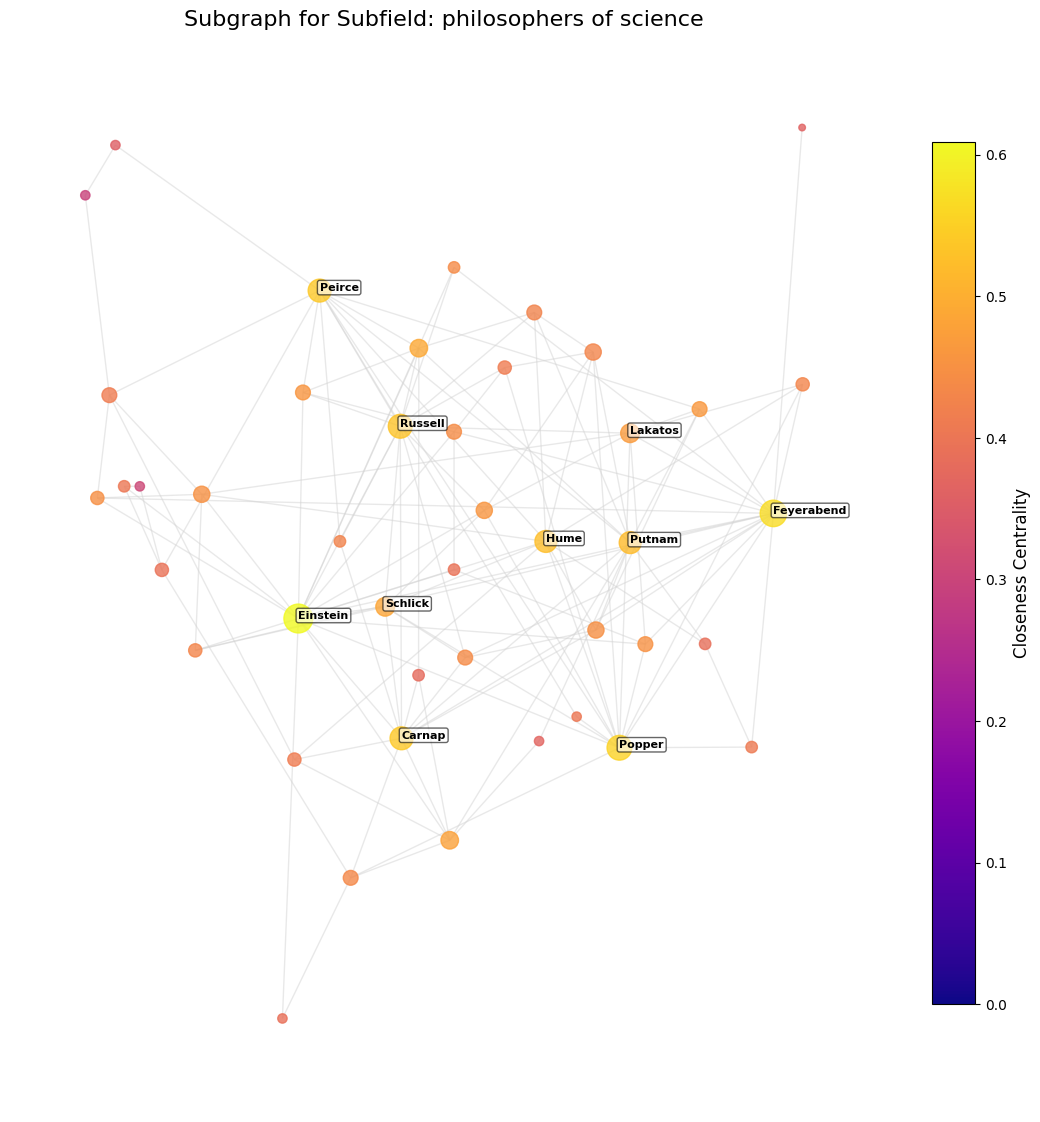

Processing subfield: political theorists
Top 10 nodes by centrality for subfield 'political theorists':
  Degree Centrality:
    Karl_Marx: 0.4722
    John_Locke: 0.2500
    Adam_Smith: 0.2500
    Aristotle: 0.2361
    Leo_Strauss: 0.2222
    Plato: 0.2222
    Friedrich_Hayek: 0.2222
    Immanuel_Kant: 0.2083
    Vladimir_Lenin: 0.2083
    Edmund_Burke: 0.2083
  Closeness Centrality:
    Karl_Marx: 0.6067
    John_Locke: 0.5207
    Adam_Smith: 0.5207
    Friedrich_Hayek: 0.5087
    John_Stuart_Mill: 0.5009
    Edmund_Burke: 0.5009
    Leo_Strauss: 0.4862
    Immanuel_Kant: 0.4862
    Noam_Chomsky: 0.4862
    Niccolò_Machiavelli: 0.4792
  Betweenness Centrality:
    Karl_Marx: 0.2494
    Adam_Smith: 0.0733
    Friedrich_Hayek: 0.0659
    Noam_Chomsky: 0.0627
    John_Locke: 0.0573
    Benjamin_Franklin: 0.0528
    Roger_Scruton: 0.0409
    Vladimir_Lenin: 0.0394
    Niccolò_Machiavelli: 0.0389
    Leo_Strauss: 0.0368
  Eigenvector Centrality:
    Karl_Marx: 0.3237
    John_Locke: 0.2138

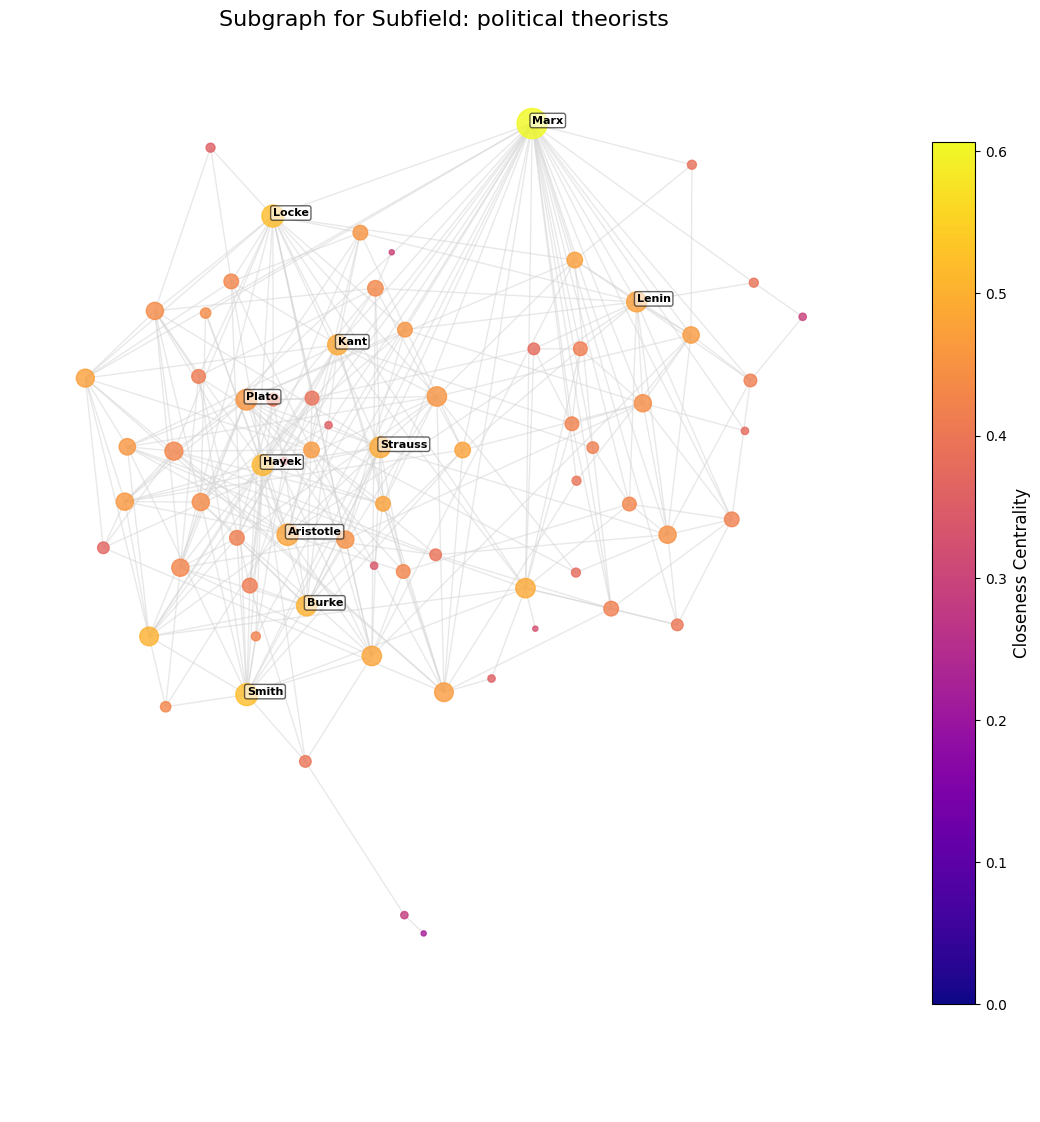

Processing subfield: philosophers of mind
Top 10 nodes by centrality for subfield 'philosophers of mind':
  Degree Centrality:
    Ludwig_Wittgenstein: 0.4464
    Hilary_Putnam: 0.2679
    David_Hume: 0.2500
    Noam_Chomsky: 0.2500
    René_Descartes: 0.2500
    Edmund_Husserl: 0.2321
    Daniel_Dennett: 0.2321
    Gilbert_Ryle: 0.2143
    Donald_Davidson_(philosopher): 0.1964
    William_James: 0.1786
  Closeness Centrality:
    Ludwig_Wittgenstein: 0.5734
    Noam_Chomsky: 0.5049
    David_Hume: 0.4941
    Daniel_Dennett: 0.4941
    Gilbert_Ryle: 0.4788
    Hilary_Putnam: 0.4788
    René_Descartes: 0.4739
    Edmund_Husserl: 0.4692
    William_James: 0.4645
    John_McDowell: 0.4645
  Betweenness Centrality:
    Ludwig_Wittgenstein: 0.2562
    René_Descartes: 0.1201
    David_Hume: 0.1121
    Gilbert_Ryle: 0.0807
    Edmund_Husserl: 0.0747
    Hilary_Putnam: 0.0746
    Noam_Chomsky: 0.0726
    Wilfrid_Sellars: 0.0567
    William_James: 0.0538
    Daniel_Dennett: 0.0382
  Eigenvector

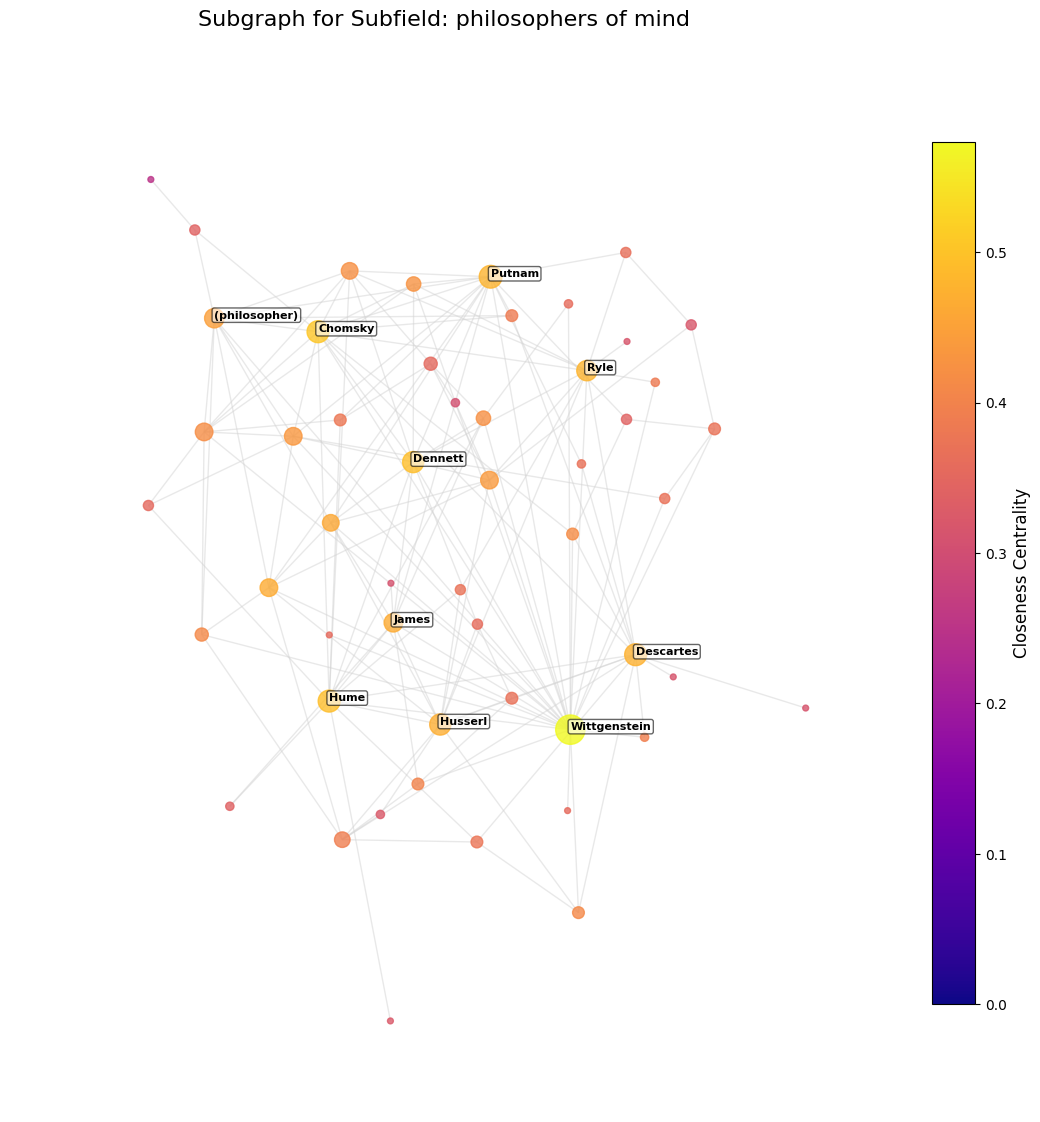

Processing subfield: political philosophers
Top 10 nodes by centrality for subfield 'political philosophers':
  Degree Centrality:
    Karl_Marx: 0.4179
    Aristotle: 0.2612
    Immanuel_Kant: 0.2537
    Friedrich_Nietzsche: 0.2537
    David_Hume: 0.2090
    Voltaire: 0.2090
    Plato: 0.2090
    Leo_Strauss: 0.2015
    John_Locke: 0.2015
    John_Stuart_Mill: 0.1940
  Closeness Centrality:
    Karl_Marx: 0.6111
    Immanuel_Kant: 0.5455
    Friedrich_Nietzsche: 0.5410
    Aristotle: 0.5259
    David_Hume: 0.5238
    John_Locke: 0.5218
    Leo_Strauss: 0.5177
    Voltaire: 0.5177
    John_Stuart_Mill: 0.5157
    Plato: 0.5058
  Betweenness Centrality:
    Karl_Marx: 0.1768
    Friedrich_Nietzsche: 0.0704
    Aristotle: 0.0632
    Immanuel_Kant: 0.0568
    Noam_Chomsky: 0.0526
    David_Hume: 0.0514
    Voltaire: 0.0488
    Plato: 0.0423
    Niccolò_Machiavelli: 0.0394
    John_Locke: 0.0338
  Eigenvector Centrality:
    Karl_Marx: 0.2894
    Immanuel_Kant: 0.2054
    Friedrich_Nietzsc

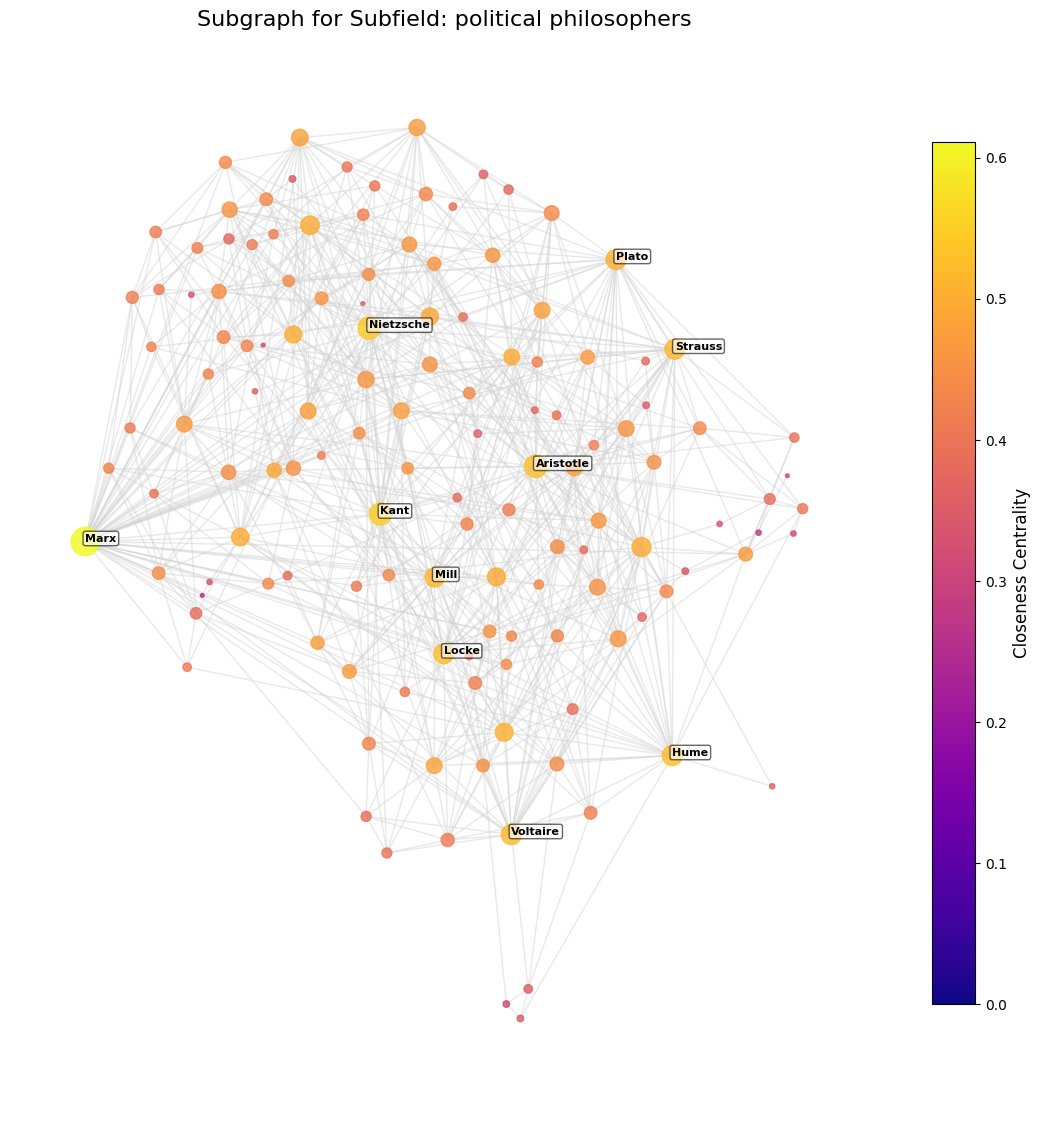

Processing subfield: phenomenologists
Top 10 nodes by centrality for subfield 'phenomenologists':
  Degree Centrality:
    Edmund_Husserl: 1.0000
    Martin_Heidegger: 0.6000
    Maurice_Merleau-Ponty: 0.4000
    Jean-Paul_Sartre: 0.4000
    Emmanuel_Levinas: 0.3000
    Edith_Stein: 0.3000
    Hannah_Arendt: 0.2000
    Aron_Gurwitsch: 0.2000
    Roman_Ingarden: 0.2000
    Alfred_Schütz: 0.1000
  Closeness Centrality:
    Edmund_Husserl: 1.0000
    Martin_Heidegger: 0.7143
    Maurice_Merleau-Ponty: 0.6250
    Jean-Paul_Sartre: 0.6250
    Emmanuel_Levinas: 0.5882
    Edith_Stein: 0.5882
    Hannah_Arendt: 0.5556
    Aron_Gurwitsch: 0.5556
    Roman_Ingarden: 0.5556
    Alfred_Schütz: 0.5263
  Betweenness Centrality:
    Edmund_Husserl: 0.6741
    Martin_Heidegger: 0.0852
    Maurice_Merleau-Ponty: 0.0222
    Edith_Stein: 0.0111
    Jean-Paul_Sartre: 0.0074
    Hannah_Arendt: 0.0000
    Alfred_Schütz: 0.0000
    Emmanuel_Levinas: 0.0000
    Herbert_Spiegelberg: 0.0000
    Aron_Gurwitsch:

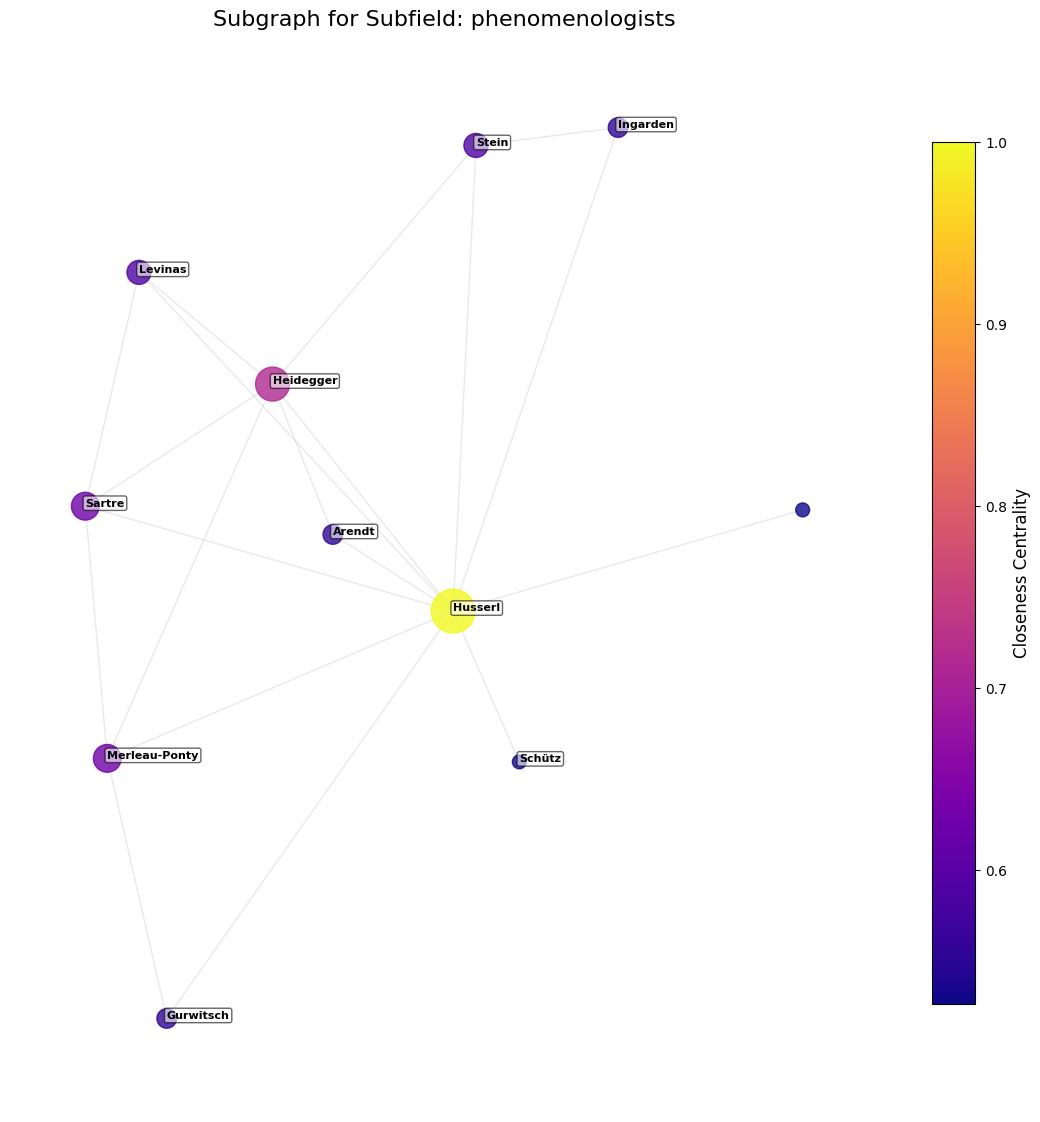

Processing subfield: feminist philosophers
Top 10 nodes by centrality for subfield 'feminist philosophers':
  Degree Centrality:
    Judith_Butler: 0.4286
    Julia_Kristeva: 0.2381
    Avital_Ronell: 0.1429
    Hannah_Arendt: 0.1429
    Hélène_Cixous: 0.1429
    Luce_Irigaray: 0.1429
    Simone_de_Beauvoir: 0.0952
    Catharine_Macaulay: 0.0952
    Martha_Nussbaum: 0.0952
    Gayatri_Chakravorty_Spivak: 0.0952
  Closeness Centrality:
    Judith_Butler: 0.4571
    Julia_Kristeva: 0.3429
    Hannah_Arendt: 0.3117
    Avital_Ronell: 0.2981
    Luce_Irigaray: 0.2981
    Simone_de_Beauvoir: 0.2857
    Martha_Nussbaum: 0.2857
    Gayatri_Chakravorty_Spivak: 0.2857
    Michèle_Le_Dœuff: 0.2637
    Nancy_Fraser: 0.2637
  Betweenness Centrality:
    Judith_Butler: 0.2310
    Hannah_Arendt: 0.0524
    Martha_Nussbaum: 0.0524
    Julia_Kristeva: 0.0341
    Avital_Ronell: 0.0127
    Luce_Irigaray: 0.0079
    Catharine_Macaulay: 0.0048
    Hélène_Cixous: 0.0048
    Jane_Addams: 0.0000
    Simone_d

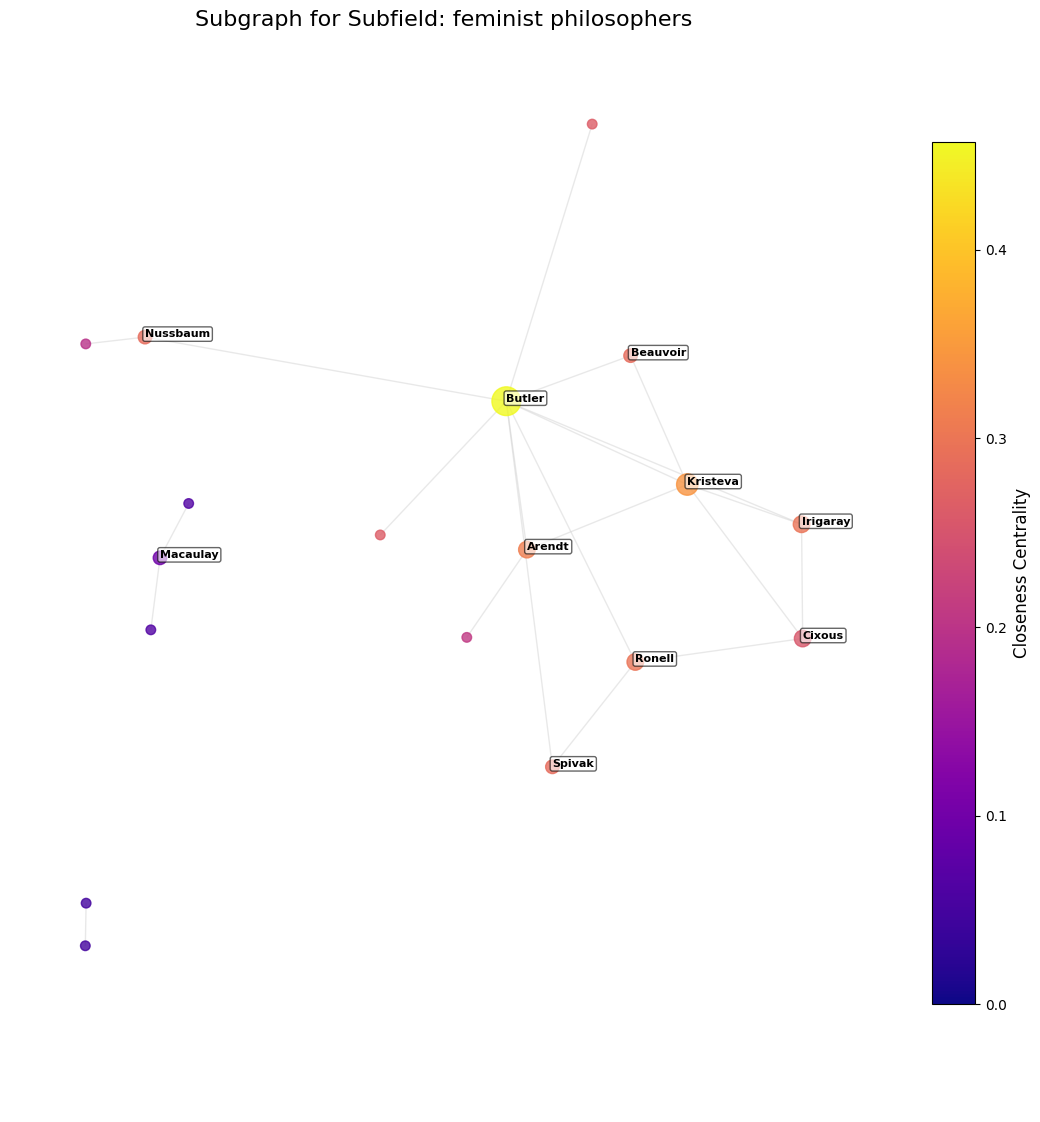

Processing subfield: utilitarians
Top 10 nodes by centrality for subfield 'utilitarians':
  Degree Centrality:
    Jeremy_Bentham: 0.4286
    John_Stuart_Mill: 0.4286
    Henry_Sidgwick: 0.2857
    Francis_Hutcheson_(philosopher): 0.2143
    Charles_Darwin: 0.1786
    Claude_Adrien_Helvétius: 0.1786
    David_Ricardo: 0.1786
    Alexander_Bain_(philosopher): 0.1786
    William_Paley: 0.1429
    Michel_Onfray: 0.1429
  Closeness Centrality:
    Jeremy_Bentham: 0.5414
    John_Stuart_Mill: 0.5275
    Claude_Adrien_Helvétius: 0.4472
    Henry_Sidgwick: 0.4472
    Francis_Hutcheson_(philosopher): 0.4286
    Leslie_Stephen: 0.4198
    Michel_Onfray: 0.4114
    Alexander_Bain_(philosopher): 0.4114
    David_Ricardo: 0.4034
    Joseph_Priestley: 0.4034
  Betweenness Centrality:
    Jeremy_Bentham: 0.2314
    John_Stuart_Mill: 0.1858
    Henry_Sidgwick: 0.1464
    Charles_Darwin: 0.1088
    William_Paley: 0.0825
    Claude_Adrien_Helvétius: 0.0737
    Francis_Hutcheson_(philosopher): 0.0701
  

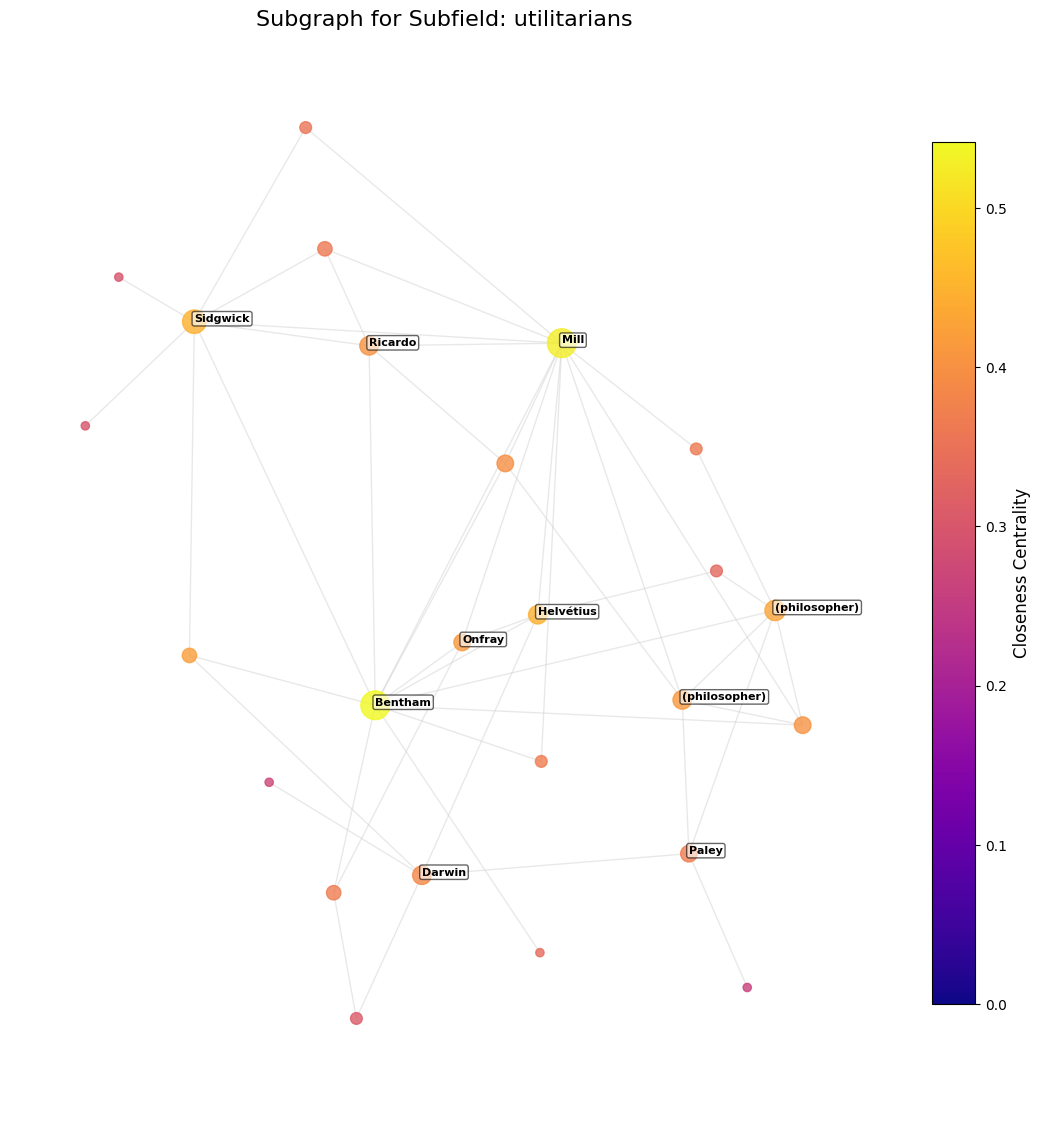

Processing subfield: environmental philosophers
Top 10 nodes by centrality for subfield 'environmental philosophers':
  Degree Centrality:
    Richard_Sylvan: 0.1429
    Peter_Singer: 0.1429
    Roger_Scruton: 0.1429
    Arne_Næss: 0.1429
    Francisco_Varela: 0.0000
    Mary_Midgley: 0.0000
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
  Closeness Centrality:
    Richard_Sylvan: 0.1429
    Peter_Singer: 0.1429
    Roger_Scruton: 0.1429
    Arne_Næss: 0.1429
    Francisco_Varela: 0.0000
    Mary_Midgley: 0.0000
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
  Betweenness Centrality:
    Francisco_Varela: 0.0000
    Mary_Midgley: 0.0000
    Richard_Sylvan: 0.0000
    Peter_Singer: 0.0000
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
    Roger_Scruton: 0.0000
    Arne_Næss: 0.0000
  Eigenvector Centrality:
    Richard_Sylvan: 0.5000
    Peter_Singer: 0.5000
    Roger_Scruton: 0.5000
    Arne_Næss: 0.5000
    Francisco_Varela: 0.0000
    Mary_Midgley: 0.0000
    

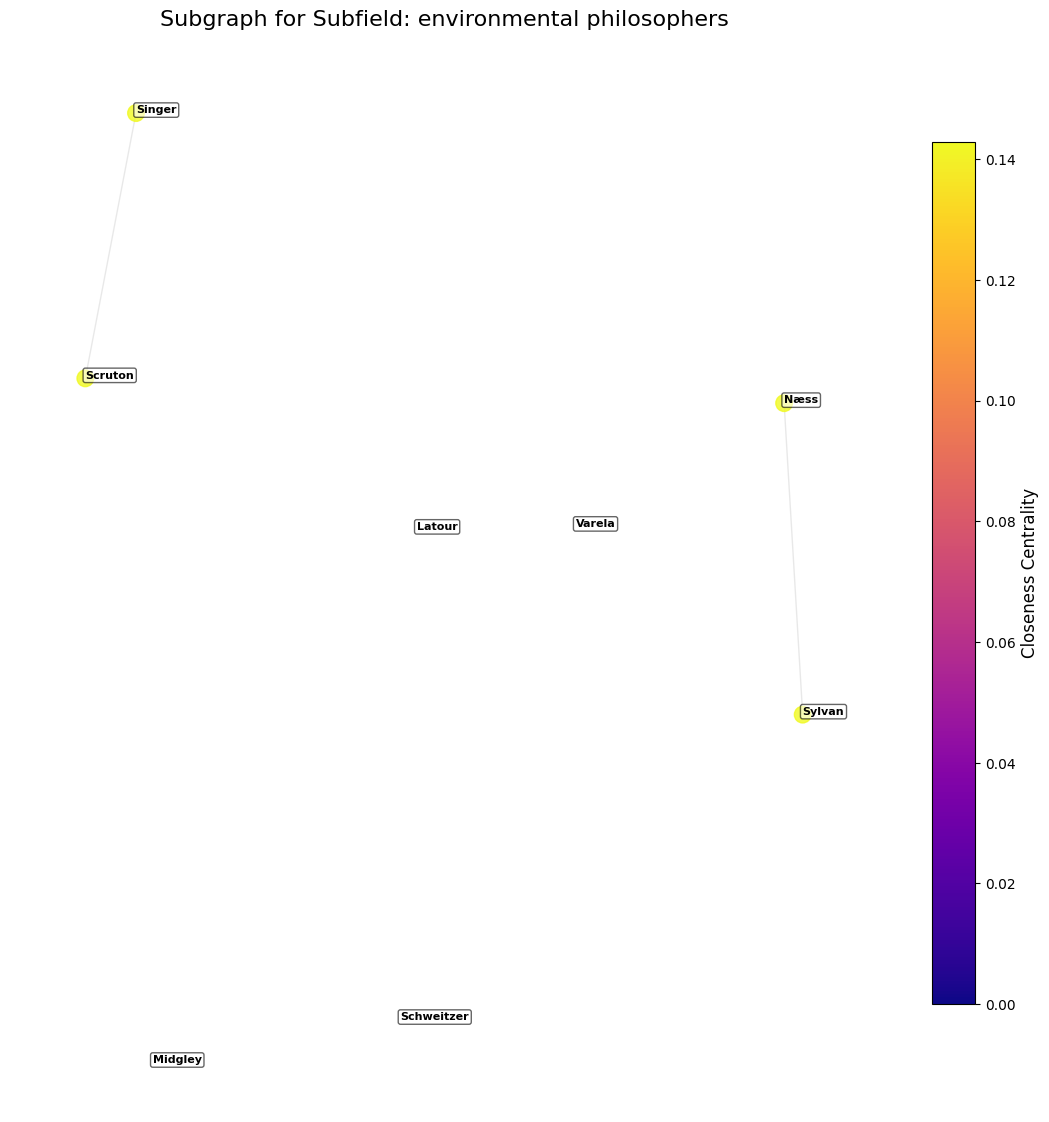

Processing subfield: philosophers of language
Top 10 nodes by centrality for subfield 'philosophers of language':
  Degree Centrality:
    Ludwig_Wittgenstein: 0.4030
    Bertrand_Russell: 0.3731
    Gottlob_Frege: 0.2985
    Noam_Chomsky: 0.2537
    Saul_Kripke: 0.2388
    Donald_Davidson_(philosopher): 0.2388
    Aristotle: 0.2388
    Hilary_Putnam: 0.2239
    Charles_Sanders_Peirce: 0.2090
    Michael_Dummett: 0.1940
  Closeness Centrality:
    Ludwig_Wittgenstein: 0.5517
    Bertrand_Russell: 0.5517
    Gottlob_Frege: 0.5216
    Saul_Kripke: 0.4946
    Noam_Chomsky: 0.4946
    Aristotle: 0.4946
    Hilary_Putnam: 0.4862
    Donald_Davidson_(philosopher): 0.4742
    John_McDowell: 0.4664
    John_Searle: 0.4627
  Betweenness Centrality:
    Ludwig_Wittgenstein: 0.1593
    Bertrand_Russell: 0.1286
    Noam_Chomsky: 0.1008
    Aristotle: 0.0963
    Saul_Kripke: 0.0664
    Gottlob_Frege: 0.0620
    John_Searle: 0.0582
    Charles_Sanders_Peirce: 0.0491
    Plato: 0.0427
    Donald_Davi

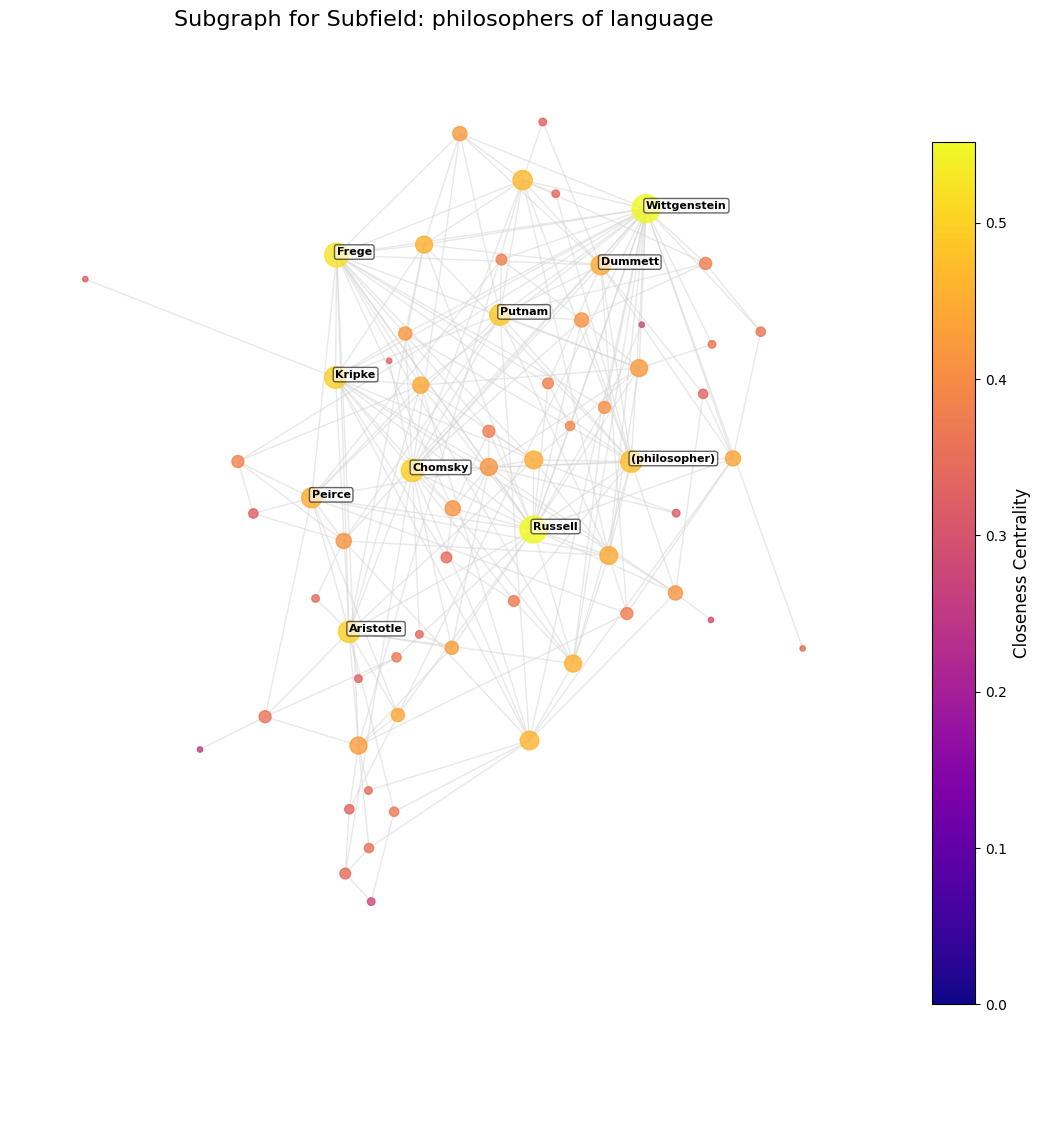

Processing subfield: epistemologists
Top 10 nodes by centrality for subfield 'epistemologists':
  Degree Centrality:
    Aristotle: 0.4286
    Plato: 0.4026
    René_Descartes: 0.3377
    Immanuel_Kant: 0.3117
    Heraclitus: 0.3117
    David_Hume: 0.2987
    Socrates: 0.2208
    John_Locke: 0.2078
    Bertrand_Russell: 0.2078
    William_James: 0.2078
  Closeness Centrality:
    Aristotle: 0.5673
    Immanuel_Kant: 0.5407
    René_Descartes: 0.5365
    Plato: 0.5324
    Heraclitus: 0.5283
    David_Hume: 0.5243
    Ludwig_Wittgenstein: 0.4943
    Charles_Sanders_Peirce: 0.4943
    Bertrand_Russell: 0.4943
    Søren_Kierkegaard: 0.4908
  Betweenness Centrality:
    Aristotle: 0.1186
    Immanuel_Kant: 0.1108
    David_Hume: 0.1059
    Plato: 0.1016
    Heraclitus: 0.0597
    Hilary_Putnam: 0.0523
    René_Descartes: 0.0492
    Alvin_Plantinga: 0.0472
    Thomas_Aquinas: 0.0402
    Baruch_Spinoza: 0.0397
  Eigenvector Centrality:
    Aristotle: 0.3016
    René_Descartes: 0.2632
    Plat

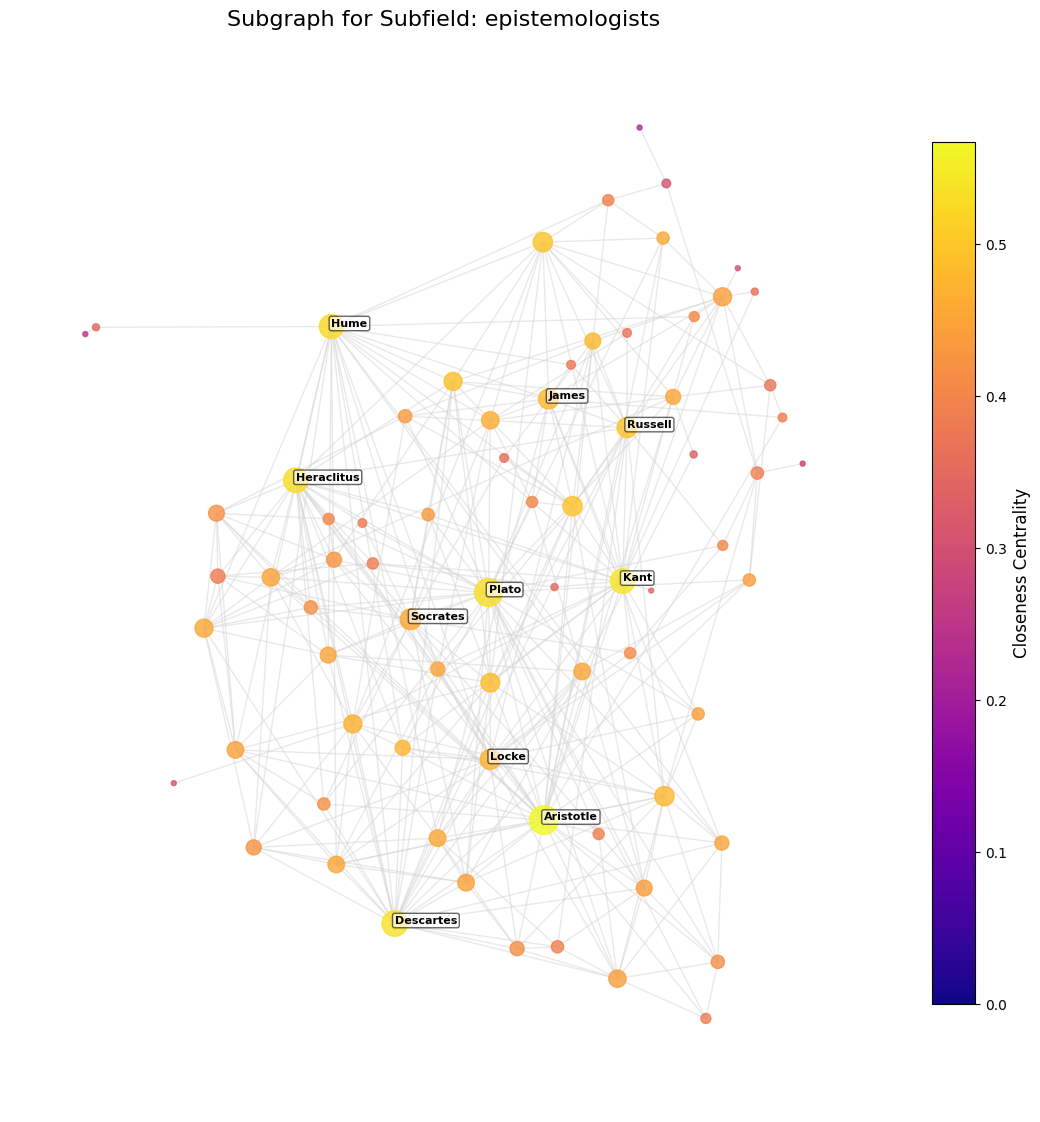

Processing subfield: critical theorists
Top 10 nodes by centrality for subfield 'critical theorists':
  Degree Centrality:
    Jürgen_Habermas: 0.2500
    Fredric_Jameson: 0.2250
    Herbert_Marcuse: 0.2250
    Antonio_Gramsci: 0.1750
    Max_Horkheimer: 0.1750
    Julia_Kristeva: 0.1500
    Paulo_Freire: 0.1250
    Slavoj_Žižek: 0.1250
    Jean_Baudrillard: 0.1250
    Leo_Löwenthal: 0.1000
  Closeness Centrality:
    Fredric_Jameson: 0.4445
    Herbert_Marcuse: 0.4225
    Max_Horkheimer: 0.4074
    Jürgen_Habermas: 0.3980
    Julia_Kristeva: 0.3934
    Antonio_Gramsci: 0.3846
    Paulo_Freire: 0.3528
    Michael_Hardt: 0.3492
    Slavoj_Žižek: 0.3492
    Raymond_Williams: 0.3457
  Betweenness Centrality:
    Fredric_Jameson: 0.2833
    Herbert_Marcuse: 0.2232
    Jürgen_Habermas: 0.2159
    Julia_Kristeva: 0.1824
    Antonio_Gramsci: 0.1615
    Paulo_Freire: 0.1459
    Jean_Baudrillard: 0.1094
    Max_Horkheimer: 0.0967
    Michael_Hardt: 0.0950
    Slavoj_Žižek: 0.0613
  Eigenvector 

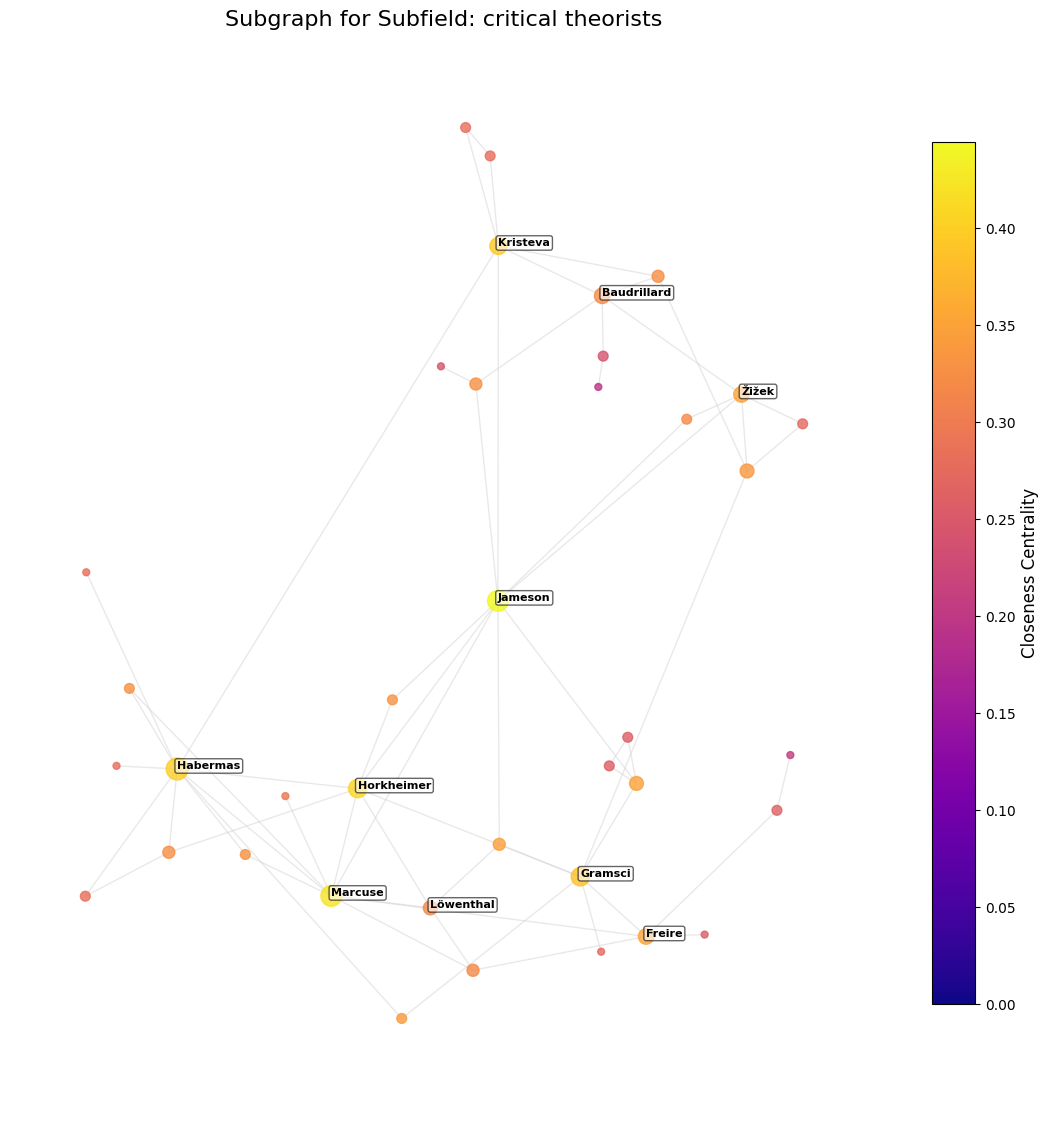

Processing subfield: metaphysicians
Top 10 nodes by centrality for subfield 'metaphysicians':
  Degree Centrality:
    Aristotle: 0.5847
    Plato: 0.4322
    Thomas_Aquinas: 0.3390
    Heraclitus: 0.2458
    Plotinus: 0.2203
    Bertrand_Russell: 0.2203
    Simplicius_of_Cilicia: 0.2119
    Martin_Heidegger: 0.2034
    Immanuel_Kant: 0.2034
    Duns_Scotus: 0.2034
  Closeness Centrality:
    Aristotle: 0.6671
    Plato: 0.5837
    Thomas_Aquinas: 0.5689
    Immanuel_Kant: 0.5213
    Bertrand_Russell: 0.5213
    Duns_Scotus: 0.5165
    Heraclitus: 0.5165
    René_Descartes: 0.5141
    Plotinus: 0.5118
    Martin_Heidegger: 0.5094
  Betweenness Centrality:
    Aristotle: 0.2924
    Thomas_Aquinas: 0.1312
    Plato: 0.1198
    Bertrand_Russell: 0.0686
    Immanuel_Kant: 0.0489
    Alvin_Plantinga: 0.0474
    Martin_Heidegger: 0.0389
    René_Descartes: 0.0385
    Duns_Scotus: 0.0355
    Heraclitus: 0.0311
  Eigenvector Centrality:
    Aristotle: 0.3685
    Plato: 0.2993
    Heraclitus: 0

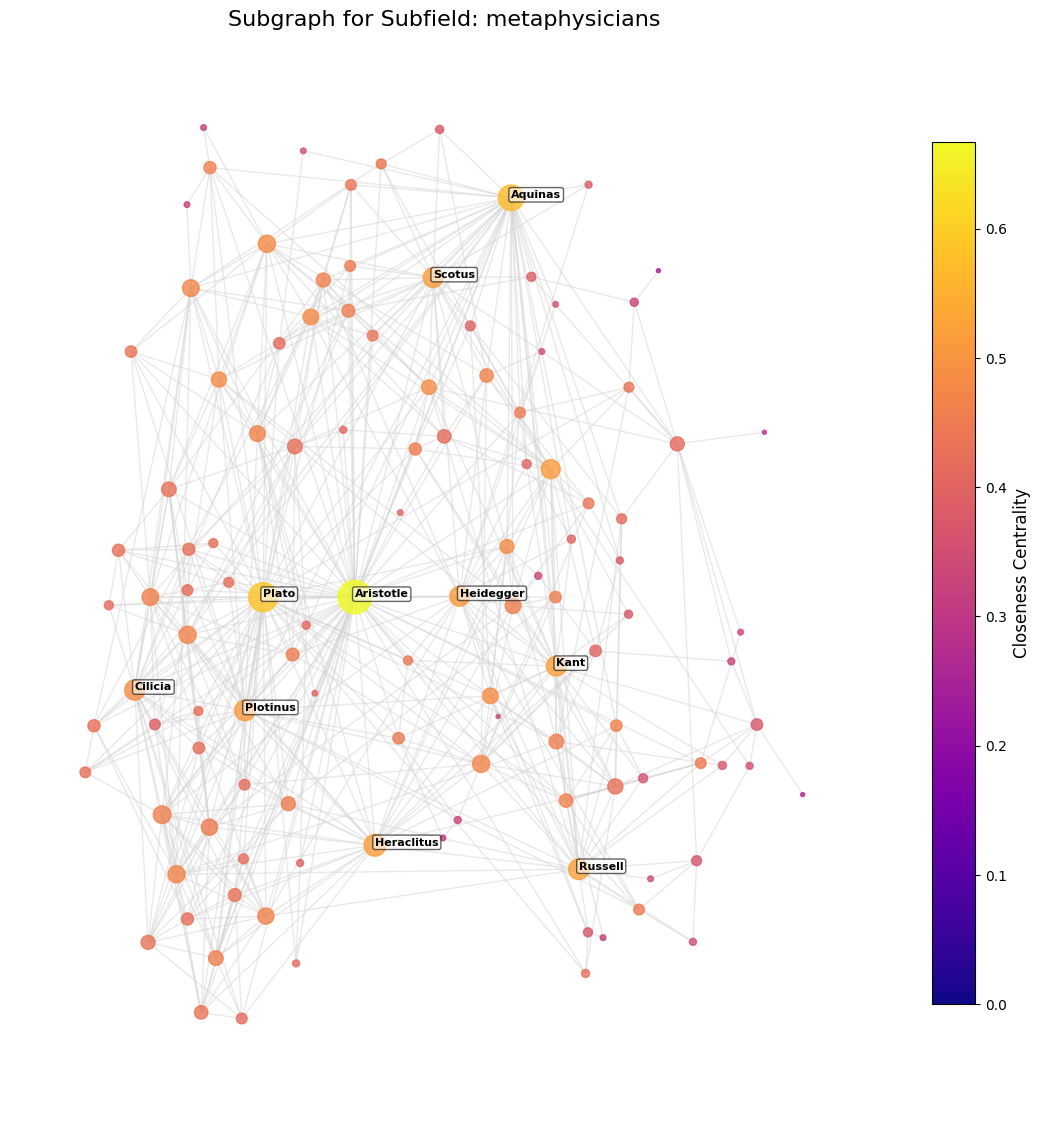

Processing subfield: existentialists
Top 10 nodes by centrality for subfield 'existentialists':
  Degree Centrality:
    Augustine_of_Hippo: 0.5000
    Martin_Heidegger: 0.3333
    Arthur_Schopenhauer: 0.3333
    Socrates: 0.1667
    Paul_Tillich: 0.1667
    Max_Stirner: 0.1667
    Mulla_Sadra: 0.0000
  Closeness Centrality:
    Augustine_of_Hippo: 0.5952
    Martin_Heidegger: 0.4630
    Arthur_Schopenhauer: 0.4630
    Socrates: 0.3788
    Paul_Tillich: 0.3205
    Max_Stirner: 0.3205
    Mulla_Sadra: 0.0000
  Betweenness Centrality:
    Augustine_of_Hippo: 0.5333
    Martin_Heidegger: 0.2667
    Arthur_Schopenhauer: 0.2667
    Socrates: 0.0000
    Paul_Tillich: 0.0000
    Max_Stirner: 0.0000
    Mulla_Sadra: 0.0000
  Eigenvector Centrality:
    Augustine_of_Hippo: 0.6280
    Martin_Heidegger: 0.4440
    Arthur_Schopenhauer: 0.4440
    Socrates: 0.3251
    Paul_Tillich: 0.2299
    Max_Stirner: 0.2299
    Mulla_Sadra: 0.0000
  Pagerank Centrality:
    Augustine_of_Hippo: 0.2752
    Marti

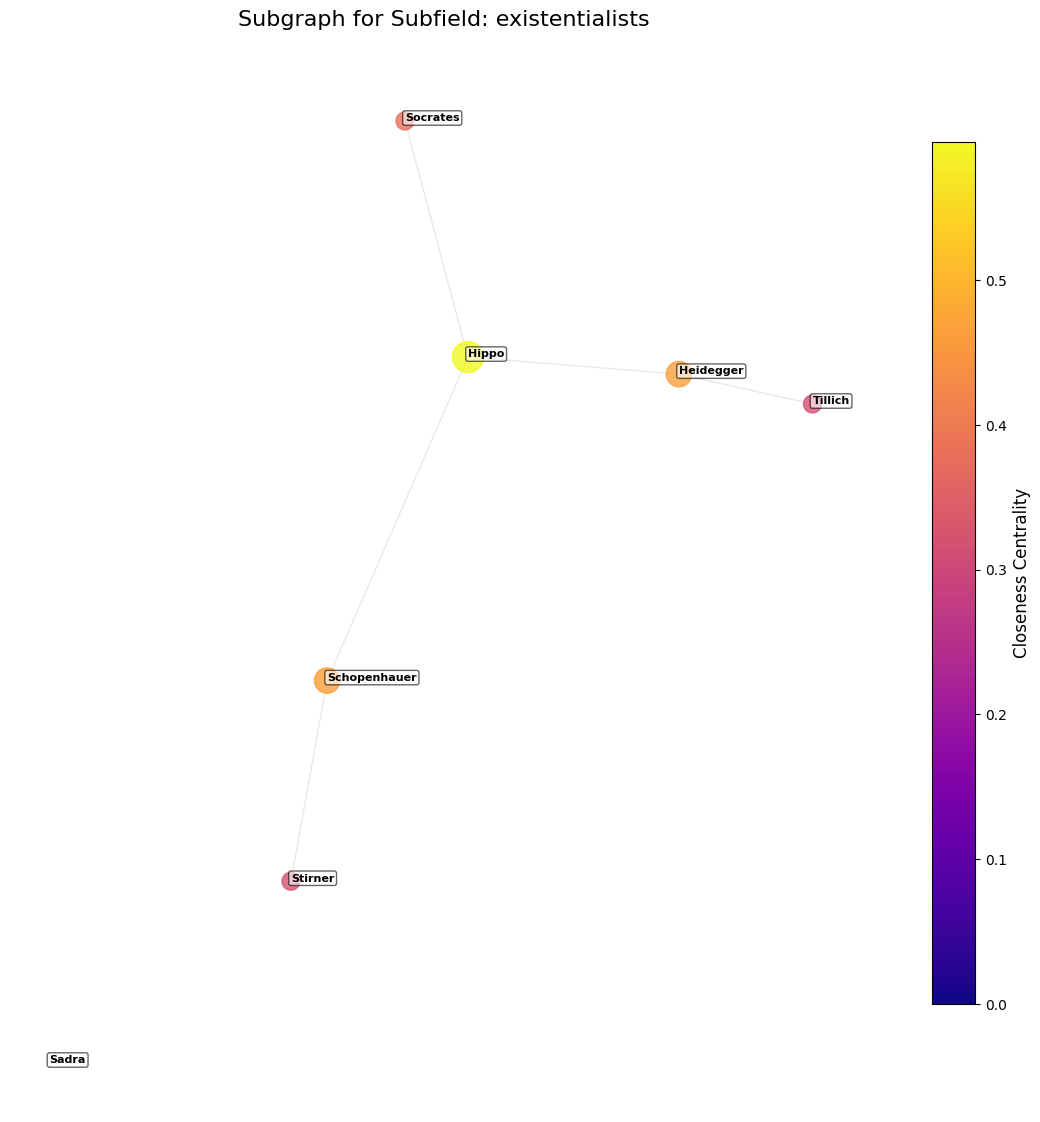

Processing subfield: secular humanists
Top 10 nodes by centrality for subfield 'secular humanists':
  Degree Centrality:
    Karl_Marx: 0.4800
    Albert_Einstein: 0.3600
    Bertrand_Russell: 0.3600
    Sigmund_Freud: 0.2400
    Noam_Chomsky: 0.2400
    Karl_Popper: 0.2400
    Martin_Heidegger: 0.2000
    John_Dewey: 0.2000
    Niels_Bohr: 0.1600
    Friedrich_Engels: 0.1600
  Closeness Centrality:
    Karl_Marx: 0.6224
    Bertrand_Russell: 0.5719
    Albert_Einstein: 0.5568
    Sigmund_Freud: 0.5038
    Karl_Popper: 0.5038
    Noam_Chomsky: 0.4921
    John_Dewey: 0.4600
    Mario_Bunge: 0.4318
    Pierre-Joseph_Proudhon: 0.4232
    Martin_Hägglund: 0.4232
  Betweenness Centrality:
    Karl_Marx: 0.3495
    Albert_Einstein: 0.1909
    Bertrand_Russell: 0.1652
    Noam_Chomsky: 0.1068
    Karl_Popper: 0.0666
    Sigmund_Freud: 0.0511
    John_Dewey: 0.0262
    Mario_Bunge: 0.0191
    Daniel_Dennett: 0.0187
    Martin_Heidegger: 0.0173
  Eigenvector Centrality:
    Karl_Marx: 0.4094
  

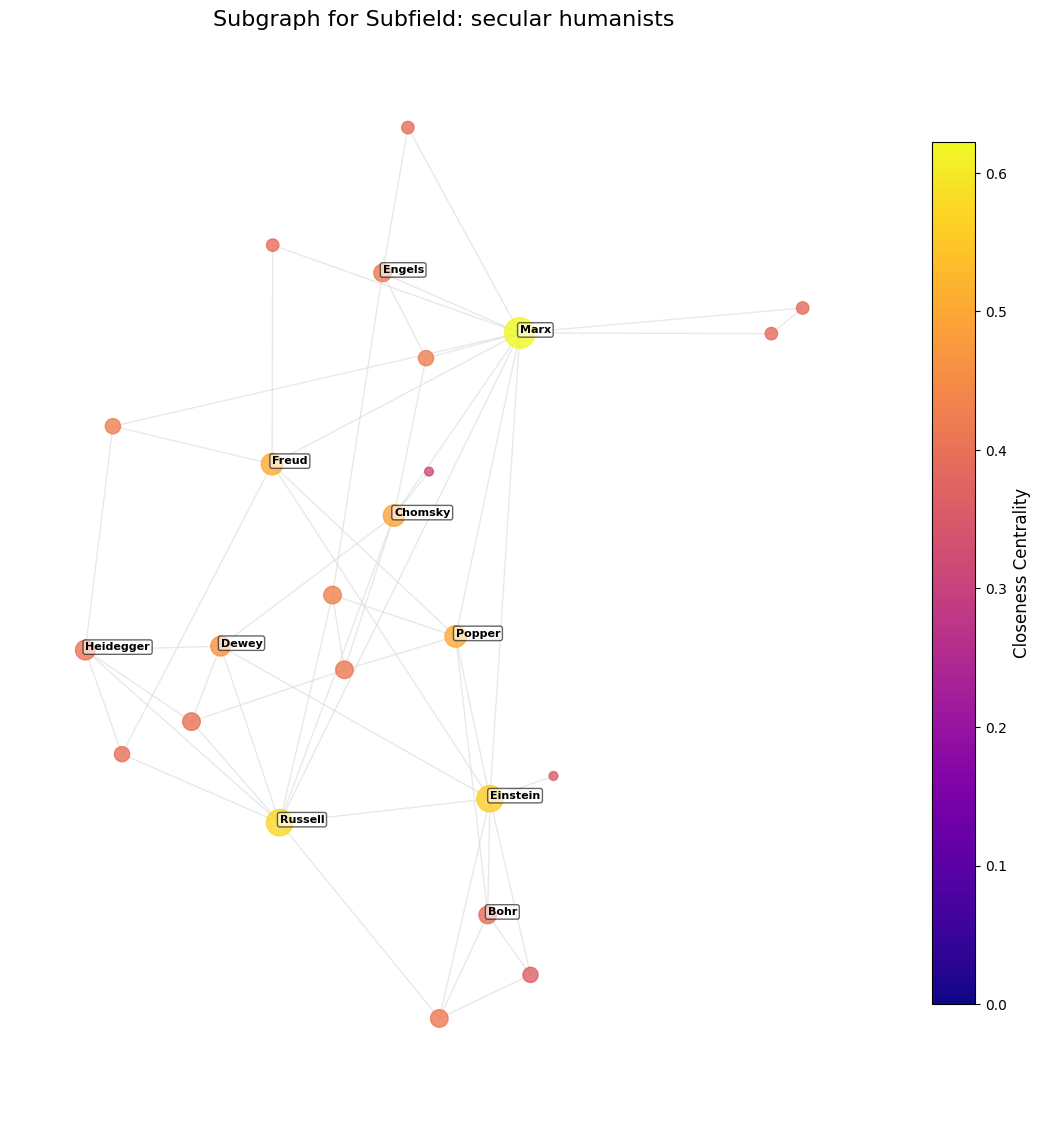

Processing subfield: logicians
Top 10 nodes by centrality for subfield 'logicians':
  Degree Centrality:
    Aristotle: 0.4091
    Bertrand_Russell: 0.2841
    Gottlob_Frege: 0.2273
    Charles_Sanders_Peirce: 0.2273
    Ludwig_Wittgenstein: 0.2045
    Alfred_Tarski: 0.2045
    Kurt_Gödel: 0.2045
    Alfred_North_Whitehead: 0.1477
    Georg_Cantor: 0.1477
    Plato: 0.1364
  Closeness Centrality:
    Aristotle: 0.5810
    Bertrand_Russell: 0.5345
    Gottlob_Frege: 0.5107
    Charles_Sanders_Peirce: 0.5011
    Alfred_Tarski: 0.4889
    Kurt_Gödel: 0.4830
    Georg_Cantor: 0.4689
    Jaakko_Hintikka: 0.4662
    René_Descartes: 0.4582
    Alfred_North_Whitehead: 0.4530
  Betweenness Centrality:
    Aristotle: 0.4017
    Alfred_Tarski: 0.1372
    Bertrand_Russell: 0.1251
    Charles_Sanders_Peirce: 0.0919
    Kurt_Gödel: 0.0732
    Ludwig_Wittgenstein: 0.0723
    Gottlob_Frege: 0.0594
    Georg_Cantor: 0.0556
    René_Descartes: 0.0418
    Alfred_North_Whitehead: 0.0341
  Eigenvector Cent

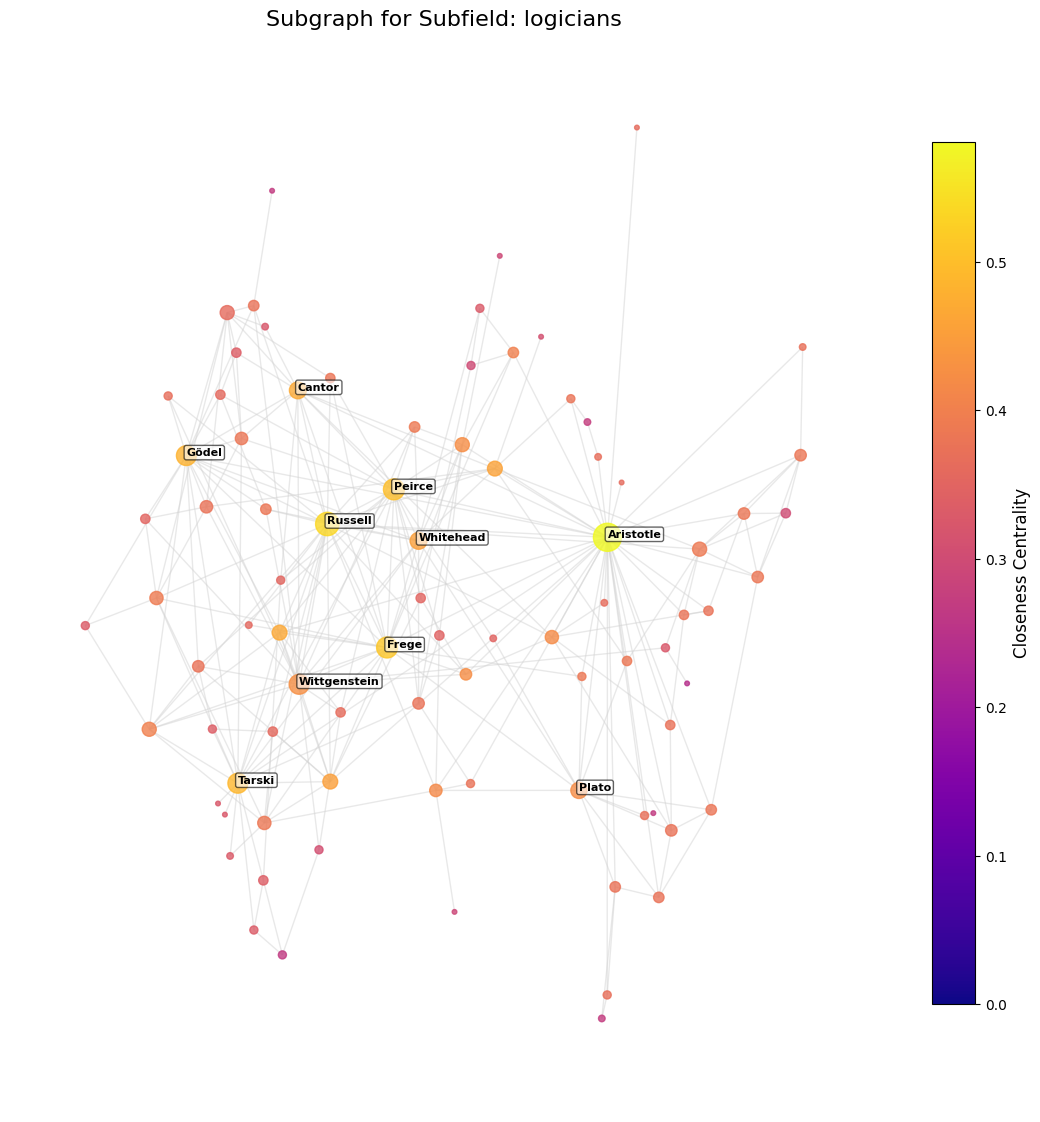

Processing subfield: philosophers of religion
Top 10 nodes by centrality for subfield 'philosophers of religion':
  Degree Centrality:
    Aristotle: 0.3958
    Plato: 0.3750
    Immanuel_Kant: 0.3542
    Maimonides: 0.2708
    Augustine_of_Hippo: 0.2500
    David_Hume: 0.2292
    Søren_Kierkegaard: 0.2292
    Vladimir_Solovyov_(philosopher): 0.1875
    Friedrich_Nietzsche: 0.1667
    William_James: 0.1667
  Closeness Centrality:
    Immanuel_Kant: 0.5450
    Plato: 0.5450
    Aristotle: 0.5450
    Maimonides: 0.4802
    Augustine_of_Hippo: 0.4690
    Søren_Kierkegaard: 0.4636
    Vladimir_Solovyov_(philosopher): 0.4583
    Emanuel_Swedenborg: 0.4532
    Al-Ghazali: 0.4481
    Anselm_of_Canterbury: 0.4432
  Betweenness Centrality:
    Aristotle: 0.1768
    Plato: 0.1653
    Immanuel_Kant: 0.1564
    Maimonides: 0.1214
    Vladimir_Solovyov_(philosopher): 0.0861
    David_Hume: 0.0704
    Søren_Kierkegaard: 0.0621
    Anselm_of_Canterbury: 0.0453
    Joseph_ibn_Tzaddik: 0.0450
    Augus

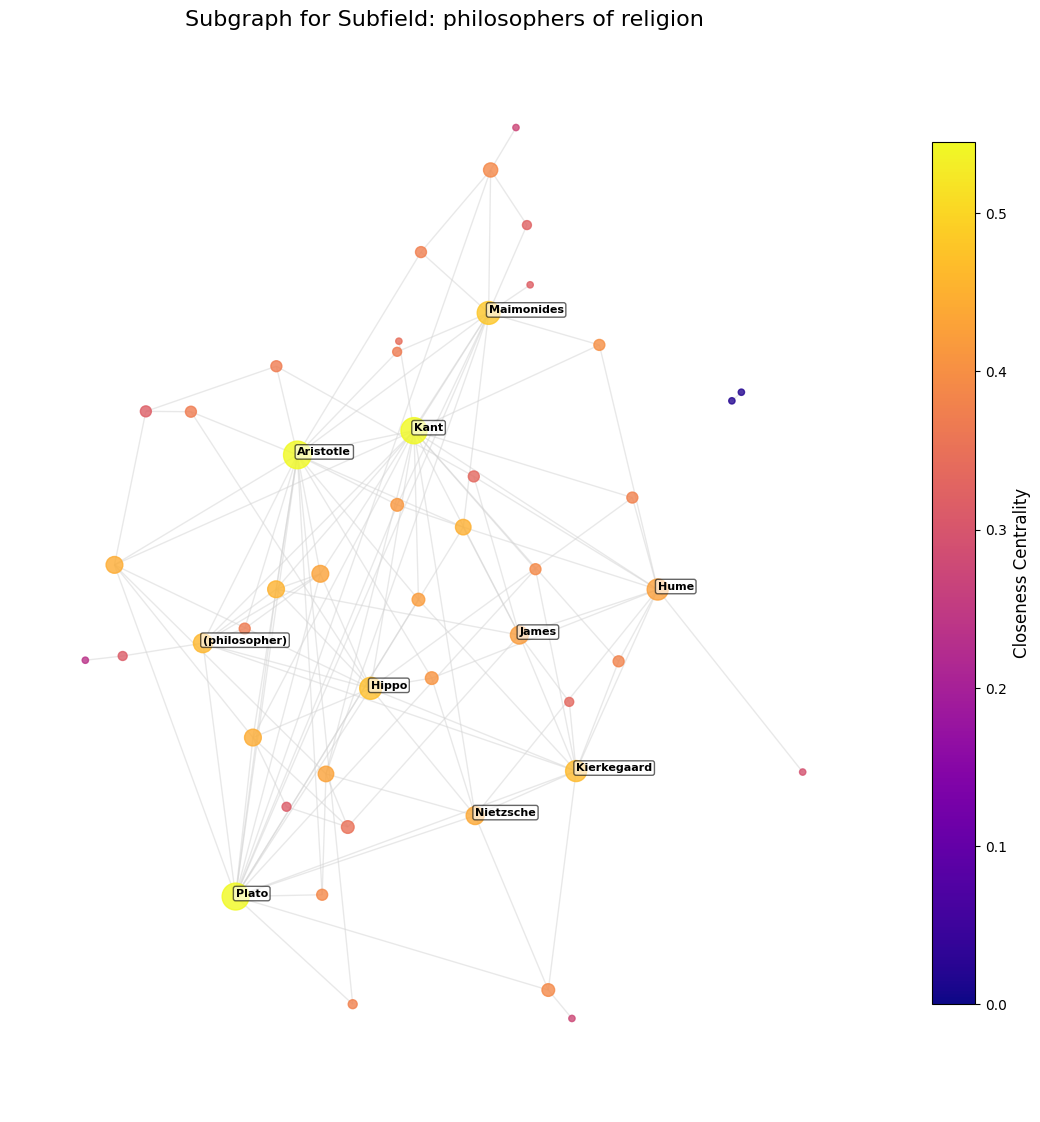

In [32]:
process_and_visualize_subfields(S_subfields, top_n=10)